In [19]:
import pandas as pd
import numpy as np
from taigapy import create_taiga_client_v3
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from statsmodels.sandbox.stats.multicomp import multipletests
from statannotations.Annotator import Annotator

# Import data

In [20]:
tc= create_taiga_client_v3()

In [21]:
crispr_dependencies = pd.read_pickle("pydata/tfs_dependencies.pkl")
Model = pd.read_pickle("pydata/model_data.pkl")

In [22]:
crispr_dependencies.fillna(0, inplace=True)

In [23]:
OmicsFusionFiltered = tc.get(name='internal-24q4-8c04', version=117, file='OmicsFusionFiltered')

In [24]:
OmicsFusionFiltered.LeftGene = OmicsFusionFiltered.LeftGene.map(lambda x: x.split(' ')[0])
OmicsFusionFiltered.RightGene = OmicsFusionFiltered.RightGene.map(lambda x: x.split(' ')[0])

In [25]:
OmicsFusionFiltered.to_pickle("pydata/OmcisFusionFiltered.pkl")

# Look at distribution of CRISPR dependencies among left vs. right genes in translocations

In [26]:
# find only TFs also found in dependencies dataset
left_gene_common_tfs = [tf for tf in OmicsFusionFiltered.LeftGene if tf in crispr_dependencies.columns]
right_gene_common_tfs = [tf for tf in OmicsFusionFiltered.RightGene if tf in crispr_dependencies.columns]

In [27]:
# filter crispr_dependencies to include only TFs also found in fusions
crispr_dependencies_tfs = crispr_dependencies.loc[:, list(set(left_gene_common_tfs + right_gene_common_tfs))]

In [28]:
crispr_dependencies_tfs

SATB2      IRF1    ZBTB7A    ZNF711    ZNF217     TBX18  \
ACH-000001  0.026632  0.021346  0.127194 -0.057932 -0.629490  0.004682   
ACH-000004 -0.137301 -0.104648  0.033475 -0.035275  0.163510  0.261518   
ACH-000005 -0.082074 -0.101387 -0.067736 -0.133567 -0.129952 -0.169527   
ACH-000007 -0.636733  0.086845 -0.437385  0.096729 -0.173074 -0.109806   
ACH-000009 -0.043598 -0.061735 -0.183455  0.039428  0.006340 -0.059060   
...              ...       ...       ...       ...       ...       ...   
ACH-003578 -0.137279 -0.029062 -0.140734 -0.135158 -0.196991  0.146348   
ACH-003580 -0.035848  0.034473 -0.209969  0.077169 -0.485983  0.130879   
ACH-003587  0.055807  0.064286 -0.232462  0.088490 -0.461780  0.097552   
ACH-003590 -0.058396  0.103537 -0.244732  0.074219 -1.177658  0.036049   
ACH-003665  0.070285  0.110344 -0.405201  0.107077 -0.403824  0.062617   

              ZNF382      PAX2   ZSCAN29     NCOA2  ...       RLF    FBXL19  \
ACH-000001 -0.609664  0.218286 -0.088584 -0.197573  ... -0.277751 -0.104411   
ACH-000004 -0.014354  0.024367 -0.301677  0.160761  ... -0.265577 -0.102999   
ACH-000005 -0.226102  0.308280 -0.096684 -0.115981  ... -0.152559 -0.194284   
ACH-000007 -0.145877 -0.161194 -0.009077 -0.030572  ...  0.039402 -0.343561   
ACH-000009 -0.135532 -0.145296 -0.069217 -0.168950  ... -0.077165 -0.116162   
...              ...       ...       ...       ...  ...       ...       ...   
ACH-003578 -0.139019  0.074210 -0.014197 -0.063274  ... -0.150198 -0.257710   
ACH-003580  0.081660 -0.121785  0.065406  0.113442  ... -0.302067 -0.068989   
ACH-003587  0.168840 -0.325164  0.168842  0.117214  ... -0.044187 -0.059130   
ACH-003590 -0.028615 -0.107905 -0.247588 -0.387459  ... -0.165956  0.037431   
ACH-003665  0.142072 -0.126529 -0.064307  0.071590  ... -0.118023 -0.067503   

               NR1I2    CSRNP3     KDM5B    ZNF264      RARA    ZNF541  \
ACH-000001 -0.163457  0.005938 -0.177110 -0.073212 -0.023879  0.089467   
ACH-000004  0.095324  0.048427 -0.052585 -0.026417 -0.208740  0.024737   
ACH-000005  0.115387 -0.156844 -0.113052  0.170684 -0.053037  0.148764   
ACH-000007  0.127075  0.048514 -0.175510  0.085875  0.223105 -0.032820   
ACH-000009  0.081122  0.135834 -0.203824  0.039243  0.015891  0.003150   
...              ...       ...       ...       ...       ...       ...   
ACH-003578  0.015725 -0.154896 -0.058951  0.026617 -0.036069 -0.026640   
ACH-003580  0.048143 -0.119996  0.028049  0.198433  0.051985  0.015567   
ACH-003587  0.128435 -0.237699 -0.086726  0.047997  0.028695 -0.001572   
ACH-003590  0.197326 -0.069133 -0.034539  0.110417 -0.111641 -0.047919   
ACH-003665  0.112373 -0.092334  0.023513  0.169388 -0.154603 -0.005679   

               TFDP2       VDR  
ACH-000001  0.025812  0.003608  
ACH-000004  0.032698 -0.275295  
ACH-000005 -0.108195 -0.005625  
ACH-000007 -0.081097  0.058342  
ACH-000009 -0.015365 -0.025105  
...              ...       ...  
ACH-003578 -0.042907  0.008591  
ACH-003580 -0.028823 -0.023014  
ACH-003587 -0.325528 -0.160936  
ACH-003590 -0.069111 -0.169547  
ACH-003665 -0.075941 -0.084854  

[1373 rows x 986 columns]

In [29]:
# merge crispr_dependencies with cell line information based on ModelID (index in crispr_dependencies)
crispr_dependencies_tfs_merge = crispr_dependencies_tfs.merge(Model[['ModelID', 'CellLineName', "OncotreeLineage", "OncotreeSubtype", "PrimaryOrMetastasis"]], left_index = True, right_on = 'ModelID')

In [30]:
crispr_dependencies_tfs_merge = crispr_dependencies_tfs_merge.melt(value_vars = set(left_gene_common_tfs + right_gene_common_tfs), id_vars= ['ModelID', 'CellLineName', "OncotreeLineage", "OncotreeSubtype", "PrimaryOrMetastasis"],
                                                    var_name = "TF", value_name = "Depmap_score")

In [31]:
crispr_dependencies_tfs_merge

ModelID   CellLineName       OncotreeLineage  \
0        ACH-000001    NIH:OVCAR-3  Ovary/Fallopian Tube   
1        ACH-000004            HEL               Myeloid   
2        ACH-000005     HEL 92.1.7               Myeloid   
3        ACH-000007          LS513                 Bowel   
4        ACH-000009         C2BBe1                 Bowel   
...             ...            ...                   ...   
1353773  ACH-003578  ES8_SLFN11-KO                  Bone   
1353774  ACH-003580      SJ-DIPGX7             CNS/Brain   
1353775  ACH-003587         531MII                  Bone   
1353776  ACH-003590         YCUB-2              Lymphoid   
1353777  ACH-003665          MBU-8               Myeloid   

                           OncotreeSubtype PrimaryOrMetastasis     TF  \
0         High-Grade Serous Ovarian Cancer          Metastatic  SATB2   
1                   Acute Myeloid Leukemia             Primary  SATB2   
2                   Acute Myeloid Leukemia                None  SATB2   
3                     Colon Adenocarcinoma             Primary  SATB2   
4                     Colon Adenocarcinoma             Primary  SATB2   
...                                    ...                 ...    ...   
1353773                      Ewing Sarcoma             Primary    VDR   
1353774   Diffuse Intrinsic Pontine Glioma                None    VDR   
1353775                       Osteosarcoma          Metastatic    VDR   
1353776  B-Lymphoblastic Leukemia/Lymphoma           Recurrent    VDR   
1353777             Acute Myeloid Leukemia                None    VDR   

         Depmap_score  
0            0.026632  
1           -0.137301  
2           -0.082074  
3           -0.636733  
4           -0.043598  
...               ...  
1353773      0.008591  
1353774     -0.023014  
1353775     -0.160936  
1353776     -0.169547  
1353777     -0.084854  

[1353778 rows x 7 columns]

In [32]:
leftgene_fusion_dependencies_df = OmicsFusionFiltered.merge(crispr_dependencies_tfs_merge, left_on= ['ModelID', 'LeftGene'], right_on= ['ModelID', 'TF'])
rightgene_fusion_dependencies_df = OmicsFusionFiltered.merge(crispr_dependencies_tfs_merge, left_on= ['ModelID', 'RightGene'], right_on= ['ModelID', 'TF'])

In [33]:
rightgene_fusion_dependencies_df['gene_side'] = "right"
leftgene_fusion_dependencies_df['gene_side']= "left"

In [34]:
concatenated_fusion_dependencies = pd.concat([leftgene_fusion_dependencies_df, rightgene_fusion_dependencies_df])

In [35]:
concatenated_fusion_dependencies

ModelID         FusionName  JunctionReadCount  SpanningFragCount  \
0     ACH-001289      PBX3--MAPKAP1                  3                  1   
1     ACH-000570  DMRTA1--LINC01239                  6                  3   
2     ACH-001838  DMRTA1--LINC01239                 16                 13   
3     ACH-001415  DMRTA1--LINC01239                  8                  4   
4     ACH-002077  DMRTA1--LINC01239                  3                  3   
...          ...                ...                ...                ...   
1612  ACH-002709      SMYD3--AHCTF1                  7                 11   
1613  ACH-003587      YLPM1--ZNF358                103                 51   
1614  ACH-003587      SNAPC1--HIF1A                  4                  1   
1615  ACH-003186         C9--ZNF131                  5                  3   
1616  ACH-002415    KIAA1217--FOXG1                  3                  0   

               SpliceType  LeftGene    LeftBreakpoint  RightGene  \
0         ONLY_REF_SPLICE      PBX3  chr9:125748623:+    MAPKAP1   
1     INCL_NON_REF_SPLICE    DMRTA1   chr9:22467906:+  LINC01239   
2     INCL_NON_REF_SPLICE    DMRTA1   chr9:22467906:+  LINC01239   
3     INCL_NON_REF_SPLICE    DMRTA1   chr9:22467906:+  LINC01239   
4     INCL_NON_REF_SPLICE    DMRTA1   chr9:22467906:+  LINC01239   
...                   ...       ...               ...        ...   
1612  INCL_NON_REF_SPLICE     SMYD3  chr1:246135175:-     AHCTF1   
1613      ONLY_REF_SPLICE     YLPM1  chr14:74764362:+     ZNF358   
1614      ONLY_REF_SPLICE    SNAPC1  chr14:61762588:+      HIF1A   
1615      ONLY_REF_SPLICE        C9   chr5:39341146:-     ZNF131   
1616  INCL_NON_REF_SPLICE  KIAA1217  chr10:24544967:+      FOXG1   

       RightBreakpoint LargeAnchorSupport  ...  RightBreakEntropy  \
0     chr9:125669907:-           YES_LDAS  ...             1.8295   
1      chr9:22674443:+           YES_LDAS  ...             1.9656   
2      chr9:22674443:+           YES_LDAS  ...             1.9656   
3      chr9:22674443:+           YES_LDAS  ...             1.9656   
4      chr9:22674443:+           YES_LDAS  ...             1.9656   
...                ...                ...  ...                ...   
1612  chr1:246916395:-           YES_LDAS  ...             1.7819   
1613   chr19:7519205:+           YES_LDAS  ...             1.9656   
1614  chr14:61720382:+           YES_LDAS  ...             1.9329   
1615   chr5:43161249:+           YES_LDAS  ...             1.5546   
1616  chr14:28769308:+           YES_LDAS  ...             1.2419   

                                                 annots  CCLE_count  \
0     ["TCGA_StarF2019","INTRACHROMOSOMAL[chr9:0.04M...           1   
1     ["CCLE_StarF2019","INTRACHROMOSOMAL[chr9:0.19M...          41   
2     ["CCLE_StarF2019","INTRACHROMOSOMAL[chr9:0.19M...          41   
3     ["CCLE_StarF2019","INTRACHROMOSOMAL[chr9:0.19M...          41   
4     ["CCLE_StarF2019","INTRACHROMOSOMAL[chr9:0.19M...          41   
...                                                 ...         ...   
1612                  ["INTRACHROMOSOMAL[chr1:0.33Mb]"]           1   
1613                 ["INTERCHROMOSOMAL[chr14--chr19]"]           1   
1614  ["INTRACHROMOSOMAL[chr14:0.01Mb]","LOCAL_REARR...           1   
1615                  ["INTRACHROMOSOMAL[chr5:3.64Mb]"]           1   
1616                 ["INTERCHROMOSOMAL[chr10--chr14]"]           1   

     CellLineName        OncotreeLineage  \
0      COG-AR-359              CNS/Brain   
1            YKG1              CNS/Brain   
2           ICC12          Biliary Tract   
3          UM-UC7  Bladder/Urinary Tract   
4          Lu-165                   Lung   
...           ...                    ...   
1612          CMS                Myeloid   
1613       531MII                   Bone   
1614       531MII                   Bone   
1615     NRH-UPS3            Soft Tissue   
1616       BT-987              CNS/Brain   

                                        OncotreeSubtype 

In [36]:
concatenated_fusion_dependencies.isnull().sum()

ModelID                  0
FusionName               0
JunctionReadCount        0
SpanningFragCount        0
SpliceType               0
LeftGene                 0
LeftBreakpoint           0
RightGene                0
RightBreakpoint          0
LargeAnchorSupport       0
FFPM                     0
LeftBreakDinuc           0
LeftBreakEntropy         0
RightBreakDinuc          0
RightBreakEntropy        0
annots                   0
CCLE_count               0
CellLineName             0
OncotreeLineage          0
OncotreeSubtype          0
PrimaryOrMetastasis    407
TF                       0
Depmap_score             0
gene_side                0
dtype: int64

<Axes: xlabel='gene_side', ylabel='Depmap_score'>

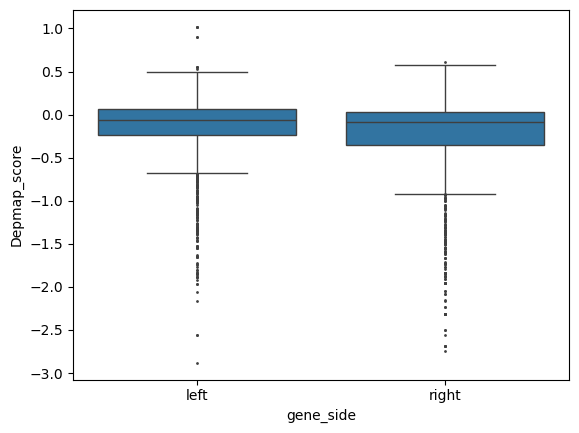

In [37]:
sns.boxplot(concatenated_fusion_dependencies, x = "gene_side" , y = "Depmap_score", fliersize= 1)

# How often are TFs that participate in translocations also a dependency?

In [38]:
# merge crispr_dependencies with cell line information based on ModelID (index in crispr_dependencies)
crispr_dependencies_merge = crispr_dependencies.merge(Model[['ModelID', 'CellLineName', "OncotreeLineage", "OncotreeSubtype", "PrimaryOrMetastasis"]], left_index = True, right_on = 'ModelID')

In [39]:
crispr_dependencies_merge

TFAP2A    TFAP2B    TFAP2C    TFAP2D    TFAP2E    ARID3A    ARID3B  \
0     0.032275 -0.052657 -0.099978 -0.040024  0.060890  0.102625 -0.121782   
3     0.145169  0.066916 -0.074218 -0.125423  0.240744 -0.105335 -0.734358   
4     0.171513 -0.361703 -0.017947 -0.103094  0.315080  0.069369 -0.026263   
6    -0.073170  0.200249 -0.292673 -0.238197 -0.059635  0.041934 -0.329979   
8     0.224490 -0.001485 -0.172446  0.018604  0.034670 -0.316335 -0.053869   
...        ...       ...       ...       ...       ...       ...       ...   
2514 -0.070363 -0.033106 -0.243238 -0.370448 -0.108596  0.023995 -0.181551   
2516 -0.081792 -0.181257 -0.381345 -0.202155  0.109083 -0.004828  0.018773   
2518 -0.128495 -0.347200 -0.229025 -0.420290  0.106401 -0.087998  0.062317   
2520  0.029615 -0.090314 -0.087541 -0.343993  0.073768 -0.087375 -0.049801   
2549 -0.016451 -0.172291 -0.208163 -0.406684  0.055806 -0.046964 -0.101909   

        ARID3C    ARID5A    ARID5B  ...     BMAL2    ZNF875     CBLL2  \
0     0.027268 -0.243864 -0.096952  ...  0.140806 -0.892911  0.215270   
3    -0.027738 -0.136107  0.008301  ... -0.090015  0.168027  0.280951   
4    -0.022071  0.006219  0.200501  ... -0.134599  0.374316 -0.018200   
6    -0.080568 -0.067746 -0.198359  ... -0.069550  0.180594  0.104287   
8     0.059077 -0.058235 -0.495861  ...  0.027901  0.098494  0.060150   
...        ...       ...       ...  ...       ...       ...       ...   
2514 -0.213355 -0.284968 -0.052868  ... -0.106350  0.018423  0.079413   
2516 -0.112690 -0.071700 -0.386106  ... -0.077457 -0.205756 -0.021425   
2518 -0.158840  0.009397 -0.086930  ...  0.210714 -0.104913 -0.141233   
2520 -0.047360  0.009253 -0.328680  ... -0.007903 -0.250206 -0.080775   
2549 -0.119825 -0.054692 -0.134542  ...  0.014795 -0.159914 -0.007127   

          ZUP1      TBXT     ModelID   CellLineName       OncotreeLineage  \
0    -0.014496  0.169385  ACH-000001    NIH:OVCAR-3  Ovary/Fallopian Tube   
3    -0.182743  0.082328  ACH-000004            HEL               Myeloid   
4    -0.283811  0.058674  ACH-000005     HEL 92.1.7               Myeloid   
6    -0.311871 -0.006005  ACH-000007          LS513                 Bowel   
8     0.014514  0.136429  ACH-000009         C2BBe1                 Bowel   
...        ...       ...         ...            ...                   ...   
2514  0.005381  0.105370  ACH-003578  ES8_SLFN11-KO                  Bone   
2516  0.016575  0.077086  ACH-003580      SJ-DIPGX7             CNS/Brain   
2518  0.058059  0.013758  ACH-003587         531MII                  Bone   
2520  0.102683  0.069626  ACH-003590         YCUB-2              Lymphoid   
2549  0.141546  0.102267  ACH-003665          MBU-8               Myeloid   

                        OncotreeSubtype  PrimaryOrMetastasis  
0      High-Grade Serous Ovarian Cancer           Metastatic  
3                Acute Myeloid Leukemia              Primary  
4                Acute Myeloid Leukemia                 None  
6                  Colon Adenocarcinoma              Primary  
8                  Colon Adenocarcinoma              Primary  
...                                 ...                  ...  
2514                      Ewing Sarcoma              Primary  
2516   Diffuse Intrinsic Pontine Glioma                 None  
2518                       Osteosarcoma           Metastatic  
2520  B-Lymphoblastic Leukemia/Lymphoma            Recurrent  
2549             Acute Myeloid Leukemia                 None  

[1373 rows x 1548 columns]

In [40]:
# merge crispr dependencies with model information
crispr_dependencies_merge = crispr_dependencies_merge.melt(value_vars = crispr_dependencies_merge.columns, id_vars= ['ModelID', 'CellLineName', "OncotreeLineage", "OncotreeSubtype", "PrimaryOrMetastasis"],
                                                    var_name = "TF", value_name = "Depmap_score")

In [41]:
crispr_dependencies_merge

ModelID   CellLineName       OncotreeLineage  \
0        ACH-000001    NIH:OVCAR-3  Ovary/Fallopian Tube   
1        ACH-000004            HEL               Myeloid   
2        ACH-000005     HEL 92.1.7               Myeloid   
3        ACH-000007          LS513                 Bowel   
4        ACH-000009         C2BBe1                 Bowel   
...             ...            ...                   ...   
2118534  ACH-003578  ES8_SLFN11-KO                  Bone   
2118535  ACH-003580      SJ-DIPGX7             CNS/Brain   
2118536  ACH-003587         531MII                  Bone   
2118537  ACH-003590         YCUB-2              Lymphoid   
2118538  ACH-003665          MBU-8               Myeloid   

                           OncotreeSubtype PrimaryOrMetastasis      TF  \
0         High-Grade Serous Ovarian Cancer          Metastatic  TFAP2A   
1                   Acute Myeloid Leukemia             Primary  TFAP2A   
2                   Acute Myeloid Leukemia                None  TFAP2A   
3                     Colon Adenocarcinoma             Primary  TFAP2A   
4                     Colon Adenocarcinoma             Primary  TFAP2A   
...                                    ...                 ...     ...   
2118534                      Ewing Sarcoma             Primary    TBXT   
2118535   Diffuse Intrinsic Pontine Glioma                None    TBXT   
2118536                       Osteosarcoma          Metastatic    TBXT   
2118537  B-Lymphoblastic Leukemia/Lymphoma           Recurrent    TBXT   
2118538             Acute Myeloid Leukemia                None    TBXT   

         Depmap_score  
0            0.032275  
1            0.145169  
2            0.171513  
3           -0.073170  
4            0.224490  
...               ...  
2118534      0.105370  
2118535      0.077086  
2118536      0.013758  
2118537      0.069626  
2118538      0.102267  

[2118539 rows x 7 columns]

In [42]:
# the list of all TFs
tf_list_reviewed = pd.read_csv('tf_list_reviewed.csv')

In [43]:
# Want to identify transcription factors involved in each translocation
# If there is only one TF in a pair, add it to tf_translocation_side_a
# If there are two TFs, add the other one to tf_translocation_side_b
OmicsFusionFiltered['tf_translocation_side_a'] = None
OmicsFusionFiltered['tf_translocation_side_b'] = None

for idx, row in OmicsFusionFiltered.iterrows():

    # assign left_gene and right_gene
    left_gene = row['LeftGene']
    right_gene = row['RightGene']
    
    # Check if LeftGene and RightGene are in the tf_list_reviewed['hugo_symbol']
    left_in_tf = left_gene in tf_list_reviewed['hugo_symbol'].values
    right_in_tf = right_gene in tf_list_reviewed['hugo_symbol'].values
    
    if left_in_tf and right_in_tf:
        # If both are present, assign one to each column
        OmicsFusionFiltered.at[idx, 'tf_translocation_side_a'] = left_gene
        OmicsFusionFiltered.at[idx, 'tf_translocation_side_b'] = right_gene
    elif left_in_tf:
        # If only LeftGene is present
        OmicsFusionFiltered.at[idx, 'tf_translocation_side_a'] = left_gene
    elif right_in_tf:
        # If only RightGene is present
        OmicsFusionFiltered.at[idx, 'tf_translocation_side_a'] = right_gene


In [44]:
# Remove any translocations that do not involve TFs
OmicsFusionFiltered_tfs = OmicsFusionFiltered[
    (OmicsFusionFiltered['tf_translocation_side_a'].notna())|
    (OmicsFusionFiltered['tf_translocation_side_b'].notna())
]

In [45]:
OmicsFusionFiltered_tfs

ModelID        FusionName  JunctionReadCount  SpanningFragCount  \
4      ACH-001113      ADNP2--PLIN3                 50                 40   
5      ACH-000705      ADNP2--PLIN3                190                 81   
57     ACH-001227     YWHAZ--ZNF706                  2                  4   
58     ACH-002979     YWHAZ--ZNF706                  2                  0   
59     ACH-001001     YWHAZ--ZNF706                  3                  0   
...           ...               ...                ...                ...   
59425  ACH-003182  TP53--AC116049.2                 55                  1   
59426  ACH-003182    ARNT--RPS27AP6                 37                  2   
59427  ACH-003182  TP53--AC116049.2                 23                  1   
59431  ACH-003182    SETD1A--FBXL19                 13                  1   
59450  ACH-002415   KIAA1217--FOXG1                  3                  0   

                SpliceType  LeftGene    LeftBreakpoint   RightGene  \
4      INCL_NON_REF_SPLICE     ADNP2  chr18:80117650:+       PLIN3   
5      INCL_NON_REF_SPLICE     ADNP2  chr18:80117650:+       PLIN3   
57         ONLY_REF_SPLICE     YWHAZ  chr8:100951929:-      ZNF706   
58         ONLY_REF_SPLICE     YWHAZ  chr8:100951929:-      ZNF706   
59         ONLY_REF_SPLICE     YWHAZ  chr8:100951929:-      ZNF706   
...                    ...       ...               ...         ...   
59425      ONLY_REF_SPLICE      TP53   chr17:7687377:-  AC116049.2   
59426  INCL_NON_REF_SPLICE      ARNT  chr1:150876543:-    RPS27AP6   
59427      ONLY_REF_SPLICE      TP53   chr17:7687377:-  AC116049.2   
59431      ONLY_REF_SPLICE    SETD1A  chr16:30969462:+      FBXL19   
59450  INCL_NON_REF_SPLICE  KIAA1217  chr10:24544967:+       FOXG1   

        RightBreakpoint LargeAnchorSupport    FFPM LeftBreakDinuc  \
4       chr19:4867657:-           YES_LDAS  1.3993             GT   
5       chr19:4867657:-           YES_LDAS  3.6475             GT   
57     chr8:101201743:-           YES_LDAS  0.0831             GT   
58     chr8:101201743:-           YES_LDAS  0.0551             GT   
59     chr8:101201743:-           YES_LDAS  0.0556             GT   
...                 ...                ...     ...            ...   
59425   chr4:66122356:+           YES_LDAS  0.6316             GT   
59426  chr1:150881705:-           YES_LDAS  0.4399             GT   
59427   chr4:66135388:+           YES_LDAS  0.2707             GT   
59431  chr16:30942116:+           YES_LDAS  0.1579             GT   
59450  chr14:28769308:+           YES_LDAS  0.1016             GT   

       LeftBreakEntropy RightBreakDinuc  RightBreakEntropy  \
4                1.7819              AG             1.8323   
5                1.7819              AG             1.8323   
57               1.7465              AG             1.9656   
58               1.7465              AG             1.9656   
59               1.7465              AG             1.9656   
...                 ...             ...                ...   
59425            1.8256              AG             1.8295   
59426            1.7232              AG             1.8892   
59427            1.8256              AG             1.8062   
59431            1.9656              AG             1.9656   
59450            1.5329              AG             1.2419   

                                                  annots  CCLE_count  \
4      ["CCLE_StarF2019","INTERCHROMOSOMAL[chr18--chr...           2   
5      ["CCLE_StarF2019","INTERCHROMOSOMAL[chr18--chr...           2   
57                     ["INTRACHROMOSOMAL[chr8:0.22Mb]"]         150   
58                     ["INTRACHROMOSOMAL[chr8:0.22Mb]"]         150   
59                     ["INTRACHROMOSOMAL[chr8:0.22Mb]"]         150   
...                                                  ...         ...   
59425                  ["INTERCHROMOSOMAL[chr17--chr4]"]           1   
59426  ["INTRACHROMOSOMAL[chr1:0.00Mb]","LOCAL_REARRA...           1   
59427                 

In [46]:
# left merge of dependencies_translocations_df_side_a with fusion data - this will retain all rows of dependenies
dependencies_translocations_df_side_a = crispr_dependencies_merge.merge(OmicsFusionFiltered_tfs, left_on= ['ModelID', 'TF'], right_on= ['ModelID', 'tf_translocation_side_a'], how = "left")

In [47]:
# translocation_tf_side_a will be NA, unless the TF is a translocation in that cell line
dependencies_translocations_df_side_a['has_translocation'] = dependencies_translocations_df_side_a.tf_translocation_side_a.notna()

In [48]:
# want only unique TFs
unique_TFs = dependencies_translocations_df_side_a.TF.unique()

In [49]:
# Calculate p-value for dependencies in cell lines where a given TF participates in translocations vs. not
tf_translocation_pvalues = []
alpha = 0.05
for tf in unique_TFs:
    filtered_df = dependencies_translocations_df_side_a.loc[dependencies_translocations_df_side_a['TF'] == tf,:]
    no_translocation_scores = filtered_df.loc[filtered_df.tf_translocation_side_a.isna(), 'Depmap_score']
    translocation_scores = filtered_df.loc[filtered_df.tf_translocation_side_a.notna(), 'Depmap_score']
    if len(no_translocation_scores) >= 5 and len(translocation_scores) >= 5:
        statistic, p_value = mannwhitneyu(no_translocation_scores, translocation_scores, alternative='two-sided')
        tf_translocation_pvalues.append(p_value)
    else:
        tf_translocation_pvalues.append(1)

In [50]:
# Multiple hypothesis testing
rejected, p_adjusted, _, alpha_corrected = multipletests(tf_translocation_pvalues, alpha=alpha, 
                               method='fdr_bh', is_sorted=False, returnsorted=False)
# Create a DataFrame
adjusted_tf_translocation_pvalues = pd.DataFrame({'TF': unique_TFs, 'p_adjusted': p_adjusted})

In [51]:
adjusted_tf_translocation_pvalues

TF  p_adjusted
0     TFAP2A         1.0
1     TFAP2B         1.0
2     TFAP2C         1.0
3     TFAP2D         1.0
4     TFAP2E         1.0
...      ...         ...
1538   BMAL2         1.0
1539  ZNF875         1.0
1540   CBLL2         1.0
1541    ZUP1         1.0
1542    TBXT         1.0

[1543 rows x 2 columns]

In [ ]:
# make boxplots of dependencies for any TF in cell lines with a translocation vs. without
def make_boxplot(tf):
    filtered_df = dependencies_translocations_df_side_a.loc[dependencies_translocations_df_side_a['TF'] == tf,:]
    no_translocation_scores = filtered_df.loc[filtered_df.tf_translocation_side_a.isna(), 'Depmap_score']
    translocation_scores = filtered_df.loc[filtered_df.tf_translocation_side_a.notna(), 'Depmap_score']
    # Example using t-tests for comparing two groups
    t_test_results = {}
    # Check if groups are large enough to perform a t-test
    
    if len(no_translocation_scores) >= 5 and len(translocation_scores) >= 5:
        statistic, p_value = mannwhitneyu(no_translocation_scores, translocation_scores, alternative='two-sided')
        boxplot = sns.boxplot(filtered_df, x = 'has_translocation', y = 'Depmap_score')
        boxplot.set_title(f'{tf} dependency scores in cell lines without versus with translocation', 
                          y = (max(filtered_df.Depmap_score) + 0.7))
        pairs = [(True, False)]
        annotator = Annotator(boxplot, pairs, data=filtered_df, x='has_translocation', y='Depmap_score')
        annotator.configure(test='Mann-Whitney', text_format='simple', loc='outside')

        annotator.apply_and_annotate()
       # plt.text(1, max(filtered_df.loc[filtered_df.tf_translocation_side_a.notna(), 'Depmap_score']) + 0.3, f'p = {p_value:.3e}', ha='center', va='bottom', fontsize=12)
        plt.text(0, min(filtered_df.loc[:, 'Depmap_score']) - 0.2 , f'n = {no_translocation_scores.shape[0]}', ha='center', va='bottom', fontsize=12)
        plt.text(1, min(filtered_df.loc[:, 'Depmap_score']) - 0.2 , f'n = {translocation_scores.shape[0]}', ha='center', va='bottom', fontsize=12)
        plt.ylim(bottom = min(filtered_df.loc[:, 'Depmap_score']) - 0.3, top = None)
        plt.show()
    else:
        print("Not enough data")


    

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:3.279e-04 U_stat=1.745e+04


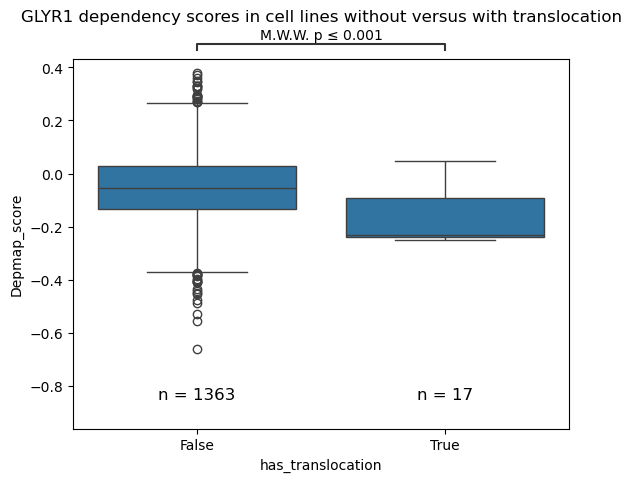

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.435e-07 U_stat=2.110e+04


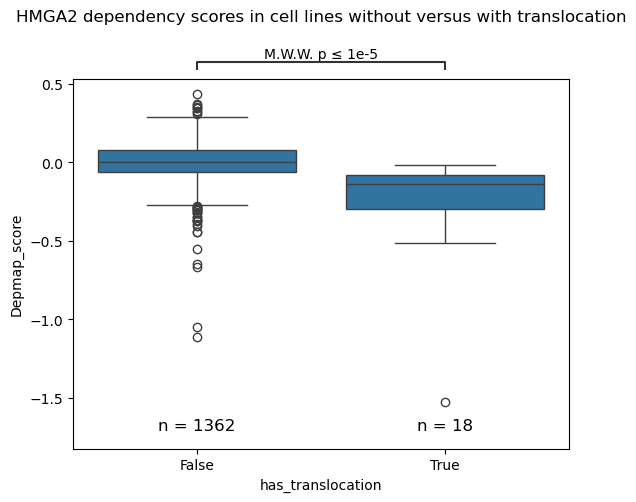

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.520e-08 U_stat=1.500e+04


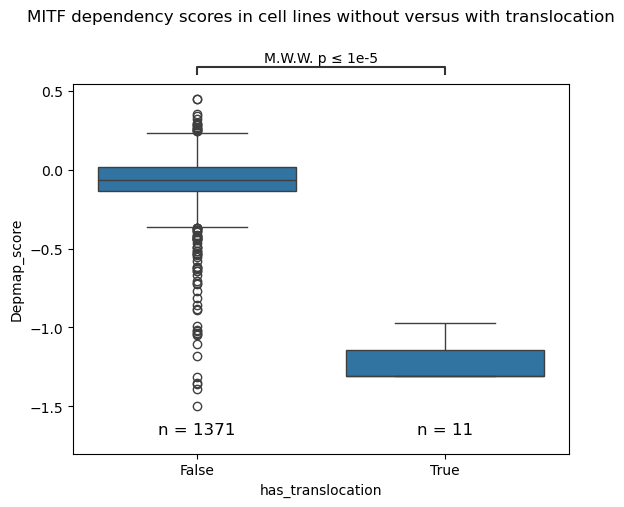

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:7.101e-06 U_stat=9.508e+03


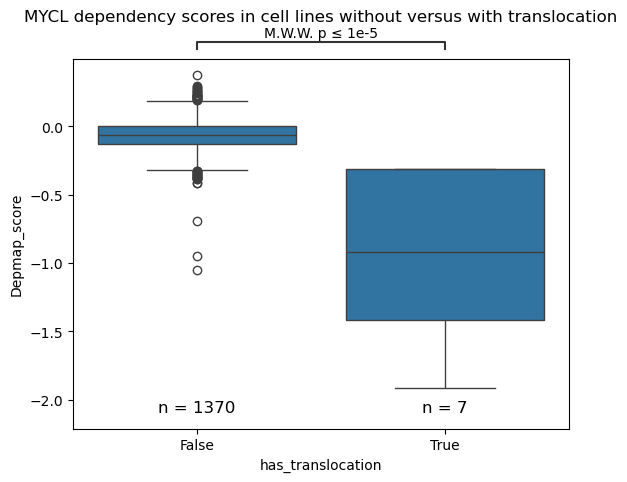

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.033e-03 U_stat=8.239e+03


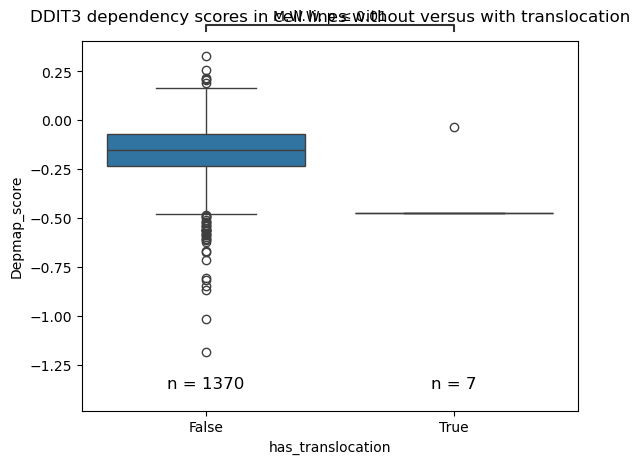

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:2.275e-07 U_stat=5.840e+03


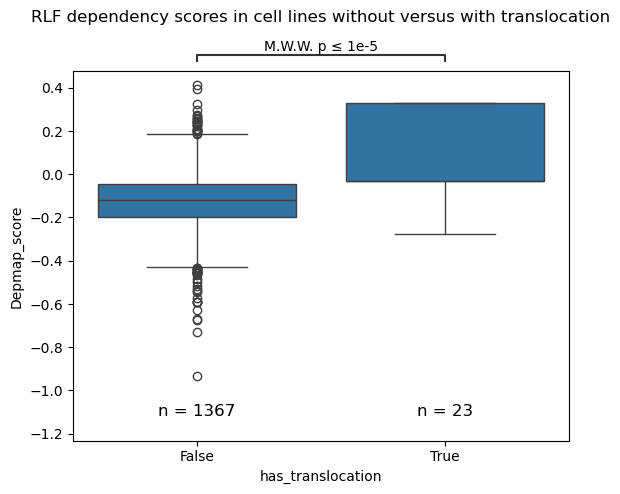

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:4.717e-05 U_stat=9.079e+03


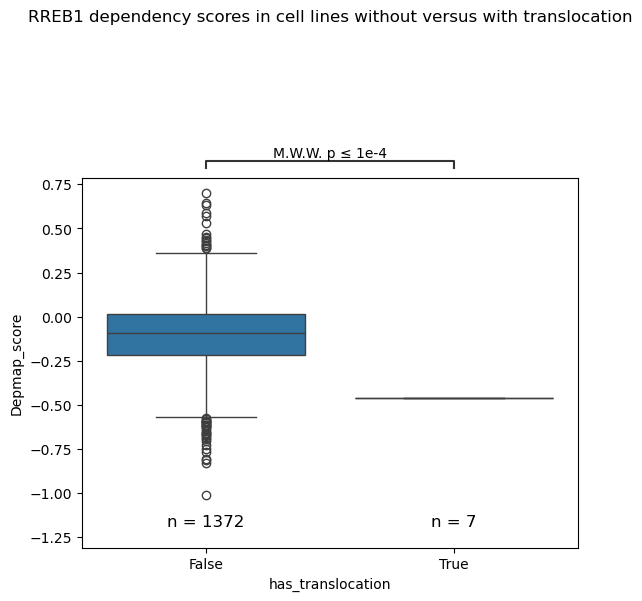

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:4.429e-04 U_stat=7.517e+03


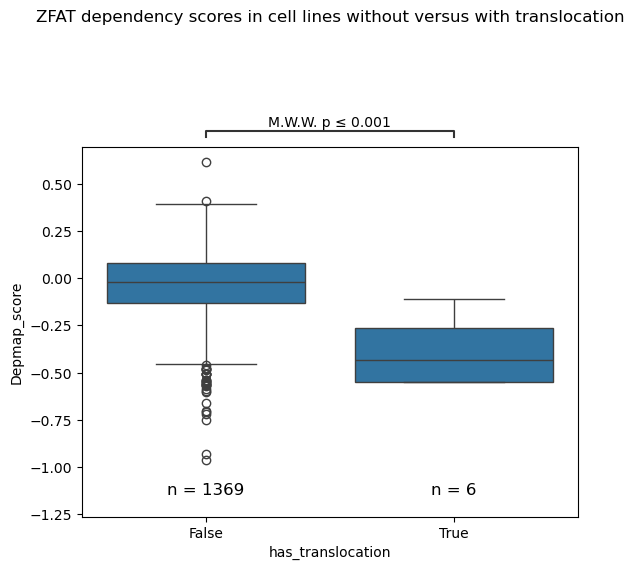

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:5.931e-05 U_stat=9.730e+02


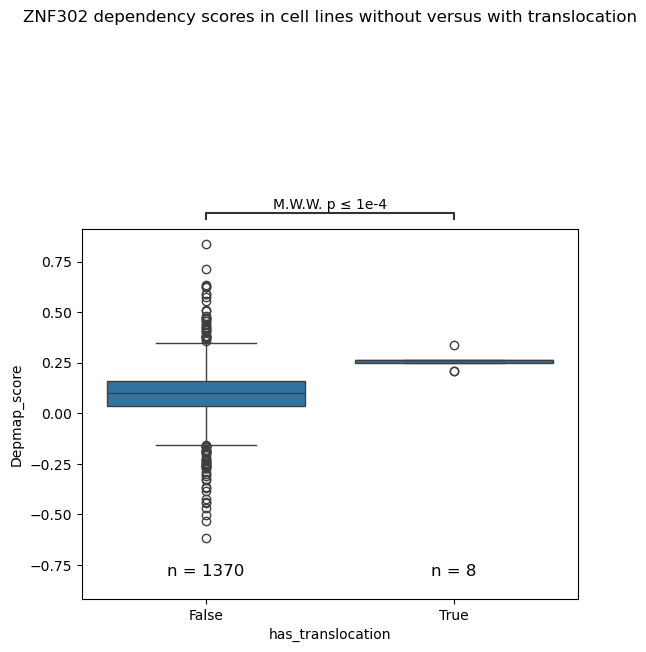

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:5.934e-05 U_stat=2.100e+02


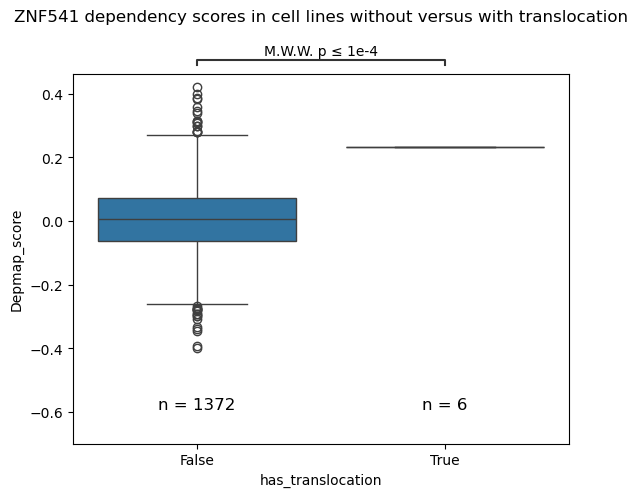

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:4.981e-04 U_stat=1.121e+04


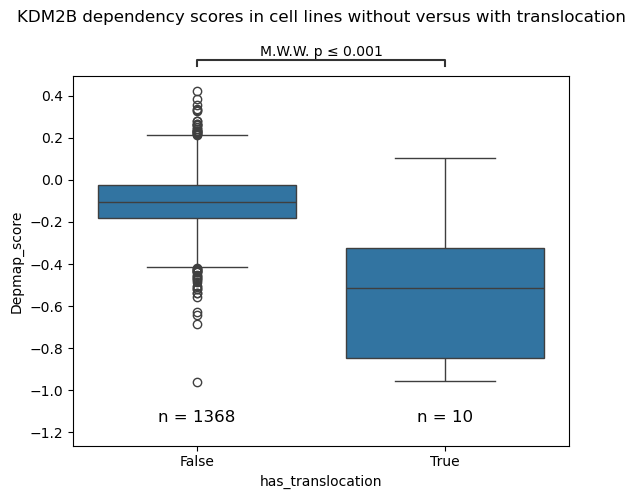

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:4.485e-08 U_stat=4.421e+04


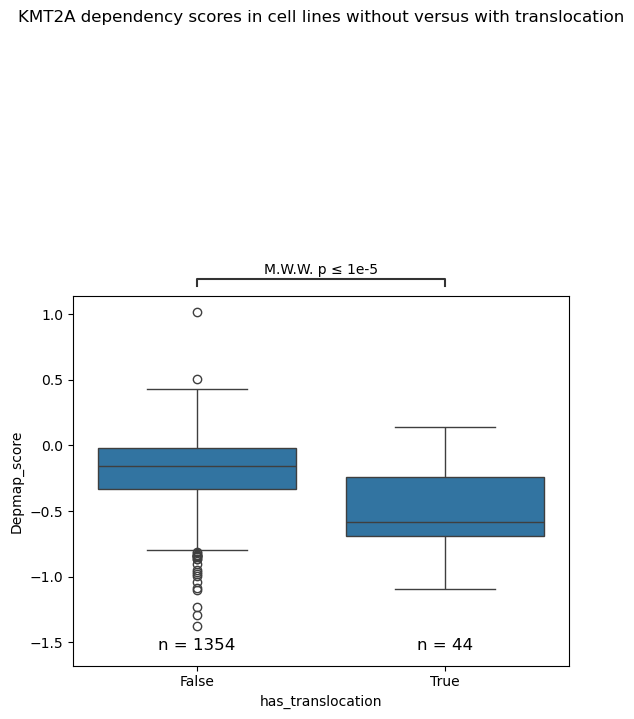

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:5.369e-05 U_stat=1.001e+04


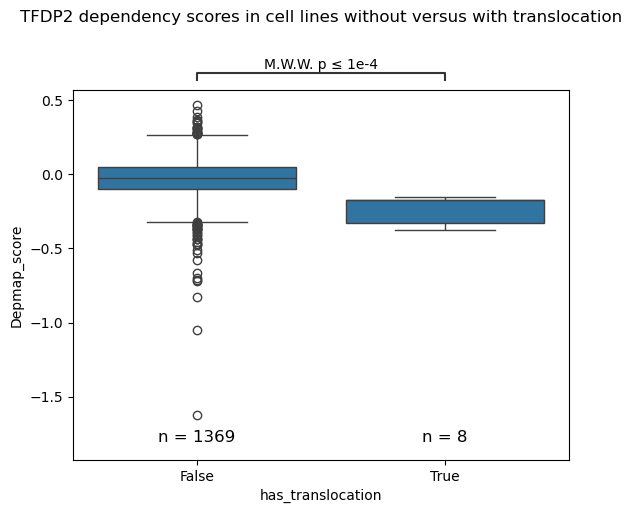

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.468e-14 U_stat=3.303e+04


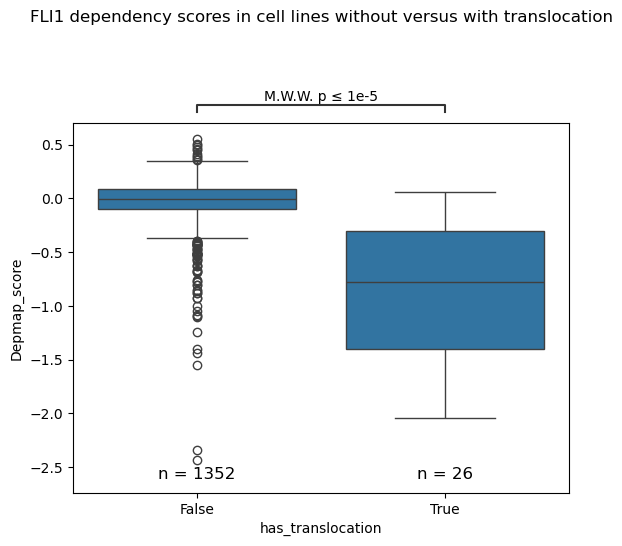

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.573e-06 U_stat=1.286e+04


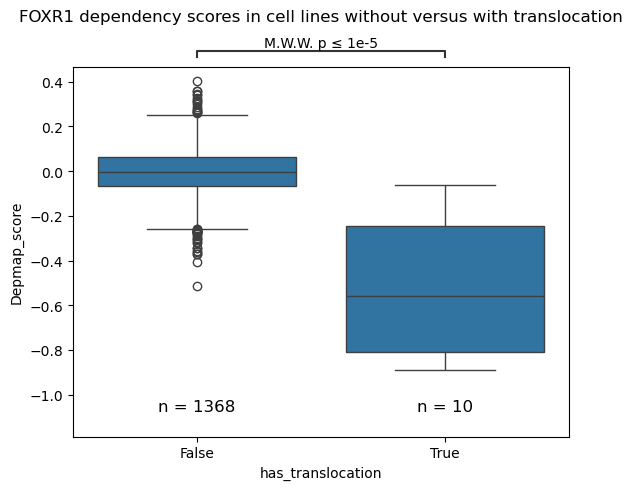

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:3.782e-05 U_stat=1.293e+04


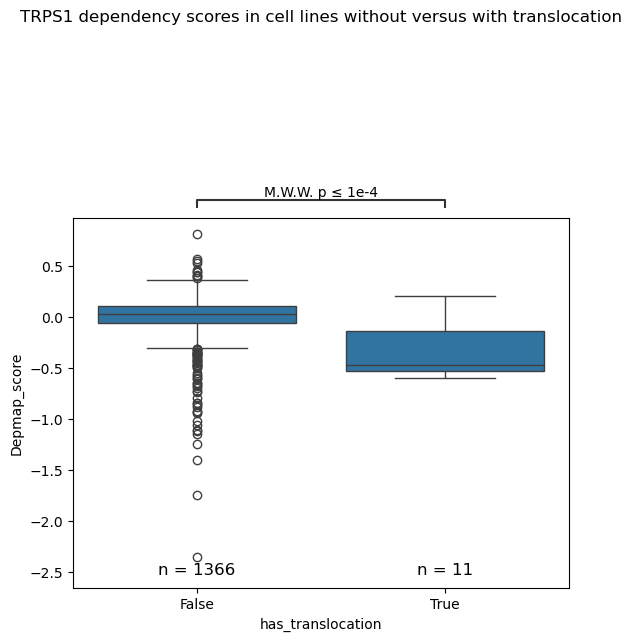

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:4.186e-04 U_stat=7.548e+03


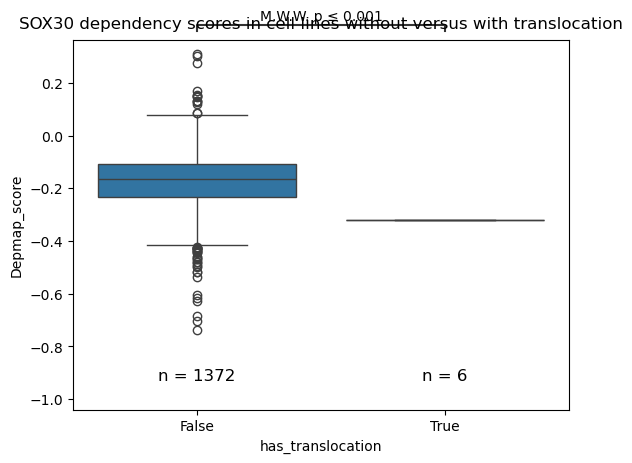

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:8.028e-05 U_stat=9.899e+03


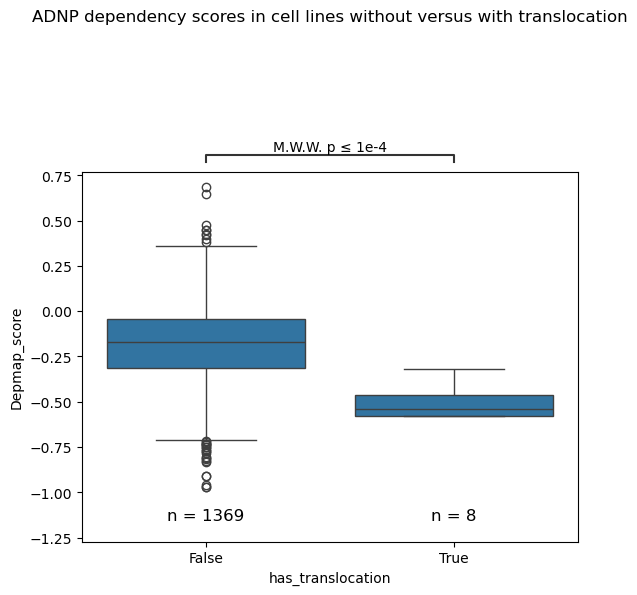

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:4.136e-06 U_stat=1.259e+04


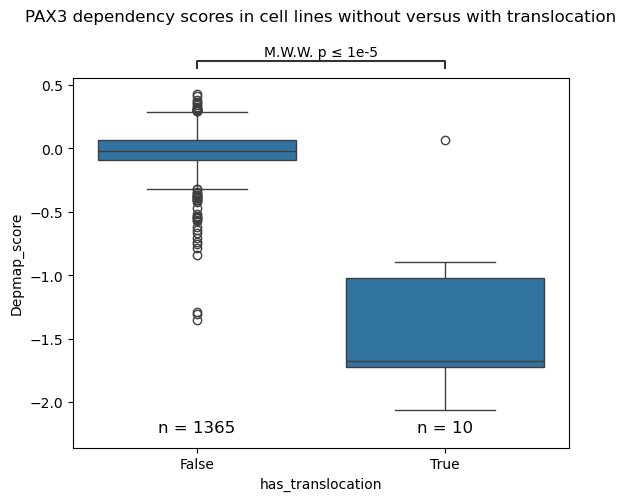

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.197e-03 U_stat=8.552e+03


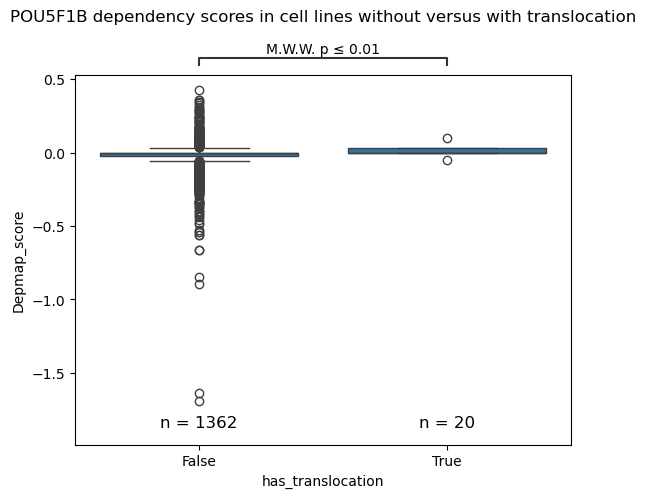

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:4.424e-07 U_stat=1.215e+04


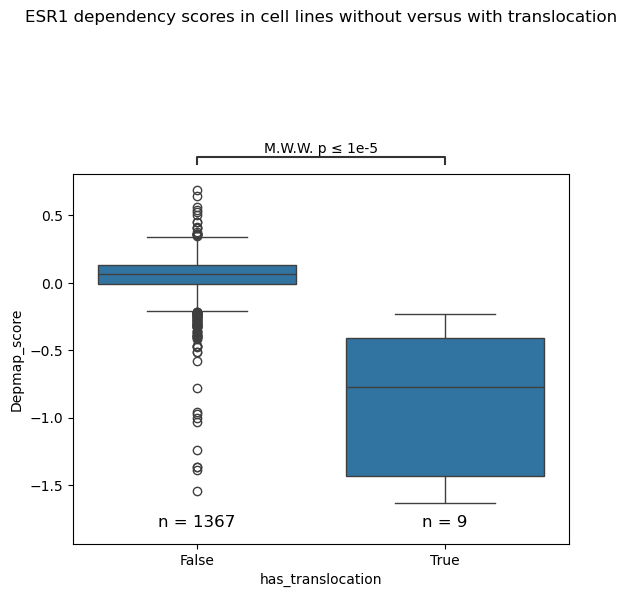

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:5.678e-24 U_stat=5.092e+04


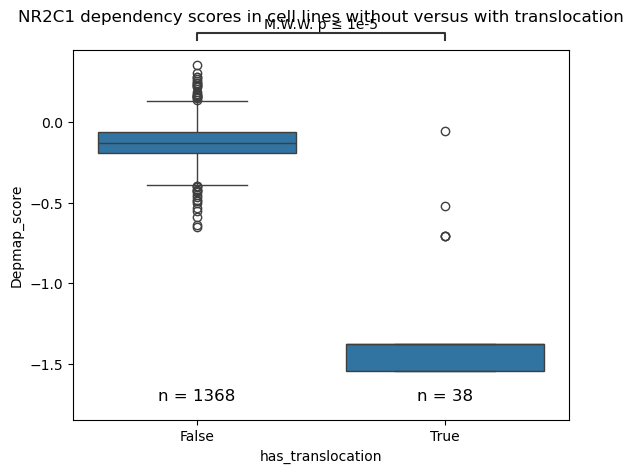

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:9.859e-05 U_stat=1.450e+04


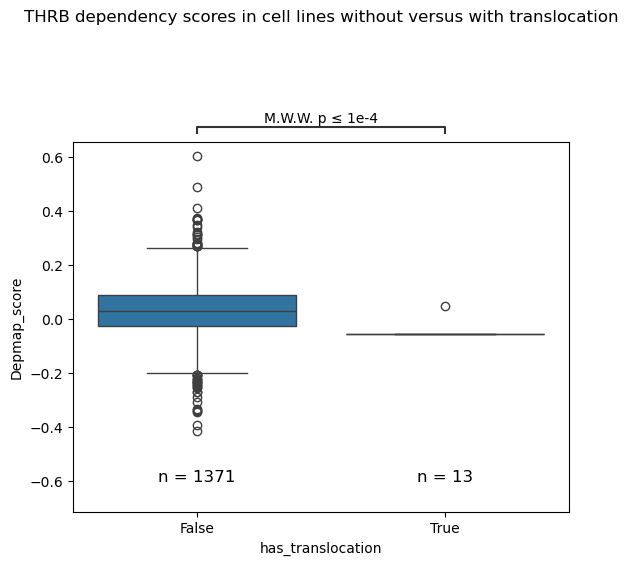

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:5.065e-04 U_stat=1.297e+04


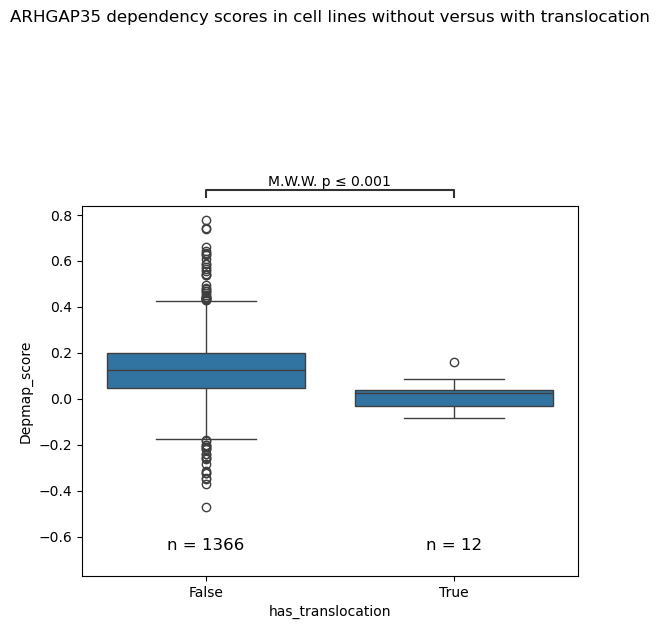

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:9.428e-04 U_stat=7.317e+03


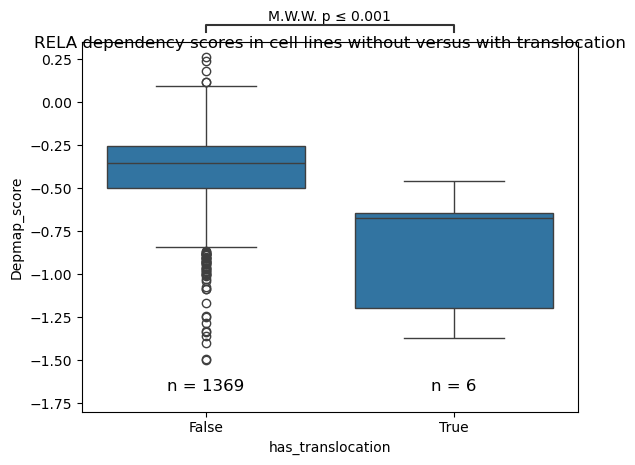

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:3.559e-05 U_stat=2.518e+04


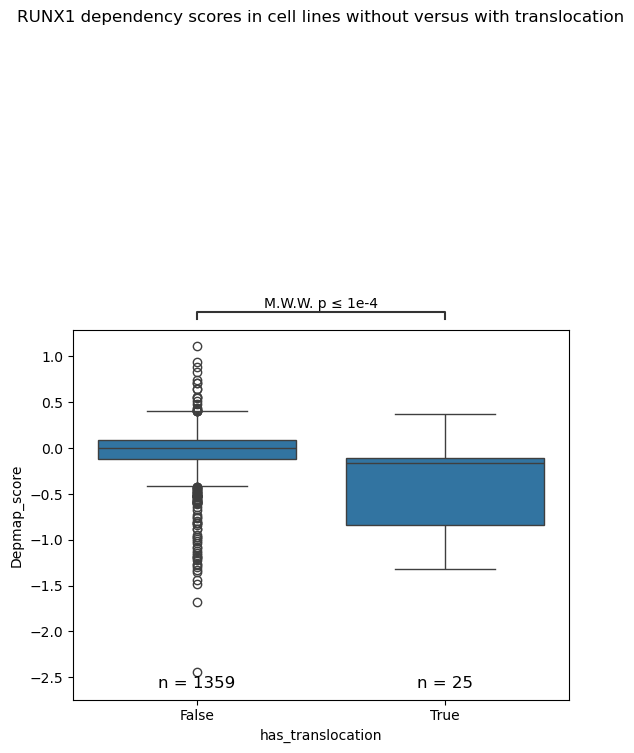

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.156e-09 U_stat=5.819e+04


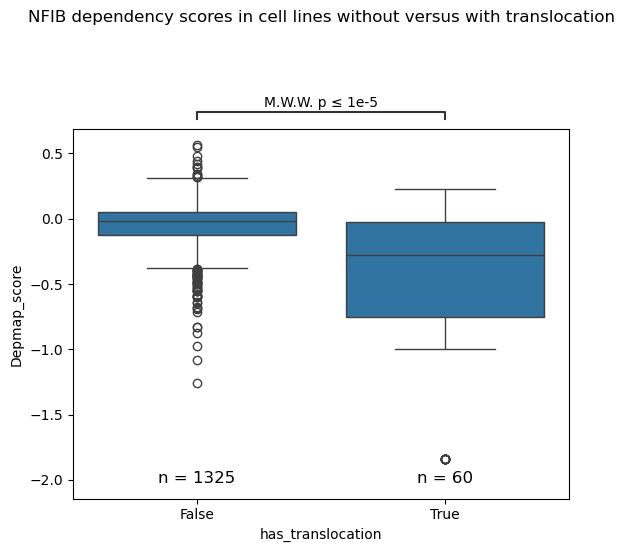

In [53]:
for tf in adjusted_tf_translocation_pvalues[p_adjusted < 0.1].TF:
    make_boxplot(tf)

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:2.512e-86 U_stat=4.556e+09


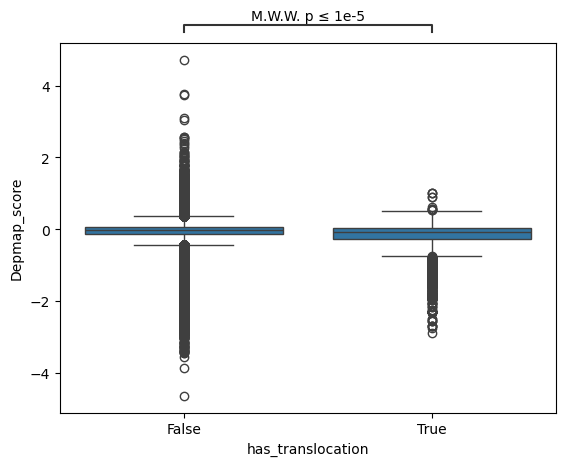

In [58]:
# also make a boxplot of dependencies across all TFs depending on whether they participate in translocations or not
#boxplot = sns.boxplot(filtered_df, x = 'has_translocation', y = 'Depmap_score')
boxplot = sns.boxplot(dependencies_translocations_df_side_a, x = 'has_translocation', y = 'Depmap_score')
pairs = [(True, False)]
annotator = Annotator(boxplot, pairs, data=dependencies_translocations_df_side_a, x='has_translocation', y='Depmap_score')
annotator.configure(test='Mann-Whitney', text_format='simple', loc='outside')
annotator.apply_and_annotate()
plt.show()

In [168]:
# make boxplots of dependencies for any TF in cell lines with a translocation vs. without while specifying a specific lineage of interest
def make_boxplot_specific_lineage(tf, lineage):
    filtered_df = dependencies_translocations_df_side_a.loc[(dependencies_translocations_df_side_a['TF'] == tf) &
                                                            (dependencies_translocations_df_side_a['OncotreeLineage'] == lineage),:]
    no_translocation_scores = filtered_df.loc[filtered_df.tf_translocation_side_a.isna(), 'Depmap_score']
    translocation_scores = filtered_df.loc[filtered_df.tf_translocation_side_a.notna(), 'Depmap_score']
    # Example using t-tests for comparing two groups
    t_test_results = {}
    # Check if groups are large enough to perform a t-test
    #print(filtered_df)
    if len(no_translocation_scores) >= 1 and len(translocation_scores) >= 1:
        statistic, p_value = mannwhitneyu(no_translocation_scores, translocation_scores, alternative='two-sided')
        boxplot = sns.boxplot(filtered_df, x = 'has_translocation', y = 'Depmap_score')
        boxplot.set_title(f'{tf} {lineage} dependency scores in cell lines without versus with translocation', 
                          y = (max(filtered_df.Depmap_score) + 1))
        pairs = [(True, False)]
        annotator = Annotator(boxplot, pairs, data=filtered_df, x='has_translocation', y='Depmap_score')
        annotator.configure(test='Mann-Whitney', text_format='simple', loc='outside')

        annotator.apply_and_annotate()
       # plt.text(1, max(filtered_df.loc[filtered_df.tf_translocation_side_a.notna(), 'Depmap_score']) + 0.3, f'p = {p_value:.3e}', ha='center', va='bottom', fontsize=12)
        plt.text(0, min(filtered_df.loc[:, 'Depmap_score']) - 0.2 , f'n = {no_translocation_scores.shape[0]}', ha='center', va='bottom', fontsize=12)
        plt.text(1, min(filtered_df.loc[:, 'Depmap_score']) - 0.2 , f'n = {translocation_scores.shape[0]}', ha='center', va='bottom', fontsize=12)
        plt.ylim(bottom = min(filtered_df.loc[:, 'Depmap_score']) - 0.3, top = None)
        plt.show()
    #else:
       # print("Not enough data")

           ModelID CellLineName OncotreeLineage  \
167677  ACH-000024        OPM-2        Lymphoid   
167694  ACH-000053   KARPAS-299        Lymphoid   
167699  ACH-000070          697        Lymphoid   
167703  ACH-000077           MJ        Lymphoid   
167719  ACH-000101        KE-37        Lymphoid   
...            ...          ...             ...   
168811  ACH-002500        Z-138        Lymphoid   
168840  ACH-002677       U-2946        Lymphoid   
168841  ACH-002678       WILL-1        Lymphoid   
169032  ACH-003590       YCUB-2        Lymphoid   
169033  ACH-003590       YCUB-2        Lymphoid   

                                          OncotreeSubtype PrimaryOrMetastasis  \
167677                                Plasma Cell Myeloma             Primary   
167694        Anaplastic Large-Cell Lymphoma ALK Positive                None   
167699  B-Lymphoblastic Leukemia/Lymphoma with t(1;19)...             Primary   
167703                          Mature T and NK Neoplasms      

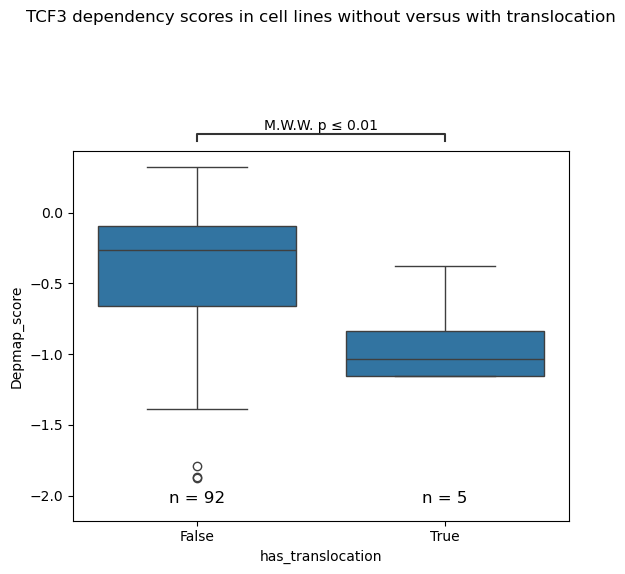

In [130]:
make_boxplot_specific_lineage('TCF3', 'Lymphoid')

In [75]:
tf_dependency_edls_expr_correlation_bylineage_dropna= pd.read_pickle("pydata/tf_dependency_e3ls_expr_correlation_bylineage_dropna.pkl")

In [76]:
unique_lineages = tf_dependency_edls_expr_correlation_bylineage_dropna.lineage.unique()

In [77]:
unique_lineages

array(['Ampulla of Vater', 'Biliary Tract', 'Bladder/Urinary Tract',
       'Bone', 'Bowel', 'Breast', 'CNS/Brain', 'Cervix',
       'Esophagus/Stomach', 'Eye', 'Head and Neck', 'Kidney', 'Liver',
       'Lung', 'Lymphoid', 'Myeloid', 'Ovary/Fallopian Tube', 'Pancreas',
       'Peripheral Nervous System', 'Pleura', 'Prostate', 'Skin',
       'Soft Tissue', 'Testis', 'Thyroid', 'Uterus', 'Vulva/Vagina'],
      dtype=object)

In [118]:
# Calculate p-value for dependencies in cell lines where a given TF participates in translocations vs. not by lineage
tf_translocation_adjusted_pvalues = []
tf_translocation_pvalues = []
alpha = 0.05
for lineage in unique_lineages:
    print(lineage)
    lineage_pvalues = []
    lineage_filtered_df = dependencies_translocations_df_side_a.loc[dependencies_translocations_df_side_a['OncotreeLineage'] == lineage,:]
    for tf in unique_TFs:
        filtered_df = lineage_filtered_df.loc[lineage_filtered_df['TF'] == tf,:]
        no_translocation_scores = filtered_df.loc[filtered_df.tf_translocation_side_a.isna(), 'Depmap_score']
        translocation_scores = filtered_df.loc[filtered_df.tf_translocation_side_a.notna(), 'Depmap_score']
        if len(no_translocation_scores) >= 5 and len(translocation_scores) >= 5:
            statistic, p_value = mannwhitneyu(no_translocation_scores, translocation_scores, alternative='two-sided')
            lineage_pvalues.append(p_value)
        else:
           lineage_pvalues.append(1)
    rejected, p_adjusted, _, alpha_corrected = multipletests(lineage_pvalues, alpha=alpha, 
                               method='fdr_bh', is_sorted=False, returnsorted=False)
    tf_translocation_adjusted_pvalues.append(p_adjusted)
    tf_translocation_pvalues.append(lineage_pvalues)


Ampulla of Vater
Biliary Tract
Bladder/Urinary Tract
Bone
Bowel
Breast
CNS/Brain
Cervix
Esophagus/Stomach
Eye
Head and Neck
Kidney
Liver
Lung
Lymphoid
Myeloid
Ovary/Fallopian Tube
Pancreas
Peripheral Nervous System
Pleura
Prostate
Skin
Soft Tissue
Testis
Thyroid
Uterus
Vulva/Vagina


In [119]:
# Create a DataFrame
tf_translocation_pvalues_lineage_df = pd.DataFrame(tf_translocation_pvalues, columns = unique_TFs).set_index(unique_lineages)

In [120]:
tf_translocation_pvalues_lineage_df

TFAP2A  TFAP2B  TFAP2C  TFAP2D  TFAP2E  ARID3A  \
Ampulla of Vater                1       1       1       1       1       1   
Biliary Tract                   1       1       1       1       1       1   
Bladder/Urinary Tract           1       1       1       1       1       1   
Bone                            1       1       1       1       1       1   
Bowel                           1       1       1       1       1       1   
Breast                          1       1       1       1       1       1   
CNS/Brain                       1       1       1       1       1       1   
Cervix                          1       1       1       1       1       1   
Esophagus/Stomach               1       1       1       1       1       1   
Eye                             1       1       1       1       1       1   
Head and Neck                   1       1       1       1       1       1   
Kidney                          1       1       1       1       1       1   
Liver                           1       1       1       1       1       1   
Lung                            1       1       1       1       1       1   
Lymphoid                        1       1       1       1       1       1   
Myeloid                         1       1       1       1       1       1   
Ovary/Fallopian Tube            1       1       1       1       1       1   
Pancreas                        1       1       1       1       1       1   
Peripheral Nervous System       1       1       1       1       1       1   
Pleura                          1       1       1       1       1       1   
Prostate                        1       1       1       1       1       1   
Skin                            1       1       1       1       1       1   
Soft Tissue                     1       1       1       1       1       1   
Testis                          1       1       1       1       1       1   
Thyroid                         1       1       1       1       1       1   
Uterus                          1       1       1       1       1       1   
Vulva/Vagina                    1       1       1       1       1       1   

                           ARID3B  ARID3C  ARID5A  ARID5B  ...  THAP6  THAP7  \
Ampulla of Vater                1       1       1       1  ...      1      1   
Biliary Tract                   1       1       1       1  ...      1      1   
Bladder/Urinary Tract           1       1       1       1  ...      1      1   
Bone                            1       1       1       1  ...      1      1   
Bowel                           1       1       1       1  ...      1      1   
Breast                          1       1       1       1  ...      1      1   
CNS/Brain                       1       1       1       1  ...      1      1   
Cervix                          1       1       1       1  ...      1      1   
Esophagus/Stomach               1       1       1       1  ...      1      1   
Eye                             1       1       1       1  ...      1      1   
Head and Neck                   1       1       1       1  ...      1      1   
Kidney                          1       1       1       1  ...      1      1   
Liver                           1       1       1       1  ...      1      1   
Lung                            1       1       1       1  ...      1      1   
Lymphoid                        1       1       1       1  ...      1      1   
Myeloid                         1       1       1       1  ...      1      1   
Ovary/Fallopian Tube            1       1       1       1  ...      1      1   
Pancreas                        1       1       1       1  ...      1      1   
Peripheral Nervous System       1       1       1       1  ...      1      1   
Pleura                          1       1       1       1  ...      1      1   
Prostate                        1       1       1       1  ...      1      1   
Skin                            1       1       1       1  ...      1      1   
Soft Tissue                   

In [128]:
for index, row in tf_translocation_pvalues_lineage_df.iterrows():
    # Find all columns where the value is less than 0.1
    columns_below_threshold = [col for col in tf_translocation_pvalues_lineage_df.columns if row[col] < 0.05]
     # Print or process the result
    print(f"Row {index}: Columns with p-value < 0.05: {columns_below_threshold}")


Row Ampulla of Vater: Columns with p-value < 0.05: []
Row Biliary Tract: Columns with p-value < 0.05: []
Row Bladder/Urinary Tract: Columns with p-value < 0.05: ['RREB1', 'PKNOX2']
Row Bone: Columns with p-value < 0.05: ['MYC', 'FLI1', 'TRPS1', 'TP53']
Row Bowel: Columns with p-value < 0.05: ['MYC']
Row Breast: Columns with p-value < 0.05: ['SOX30', 'BAZ2A', 'ESR1', 'RARA', 'ARHGAP35']
Row CNS/Brain: Columns with p-value < 0.05: ['ZNF541', 'OTX2', 'POU5F1B', 'NFIB']
Row Cervix: Columns with p-value < 0.05: ['ZNF217']
Row Esophagus/Stomach: Columns with p-value < 0.05: ['ZFHX3', 'RARA']
Row Eye: Columns with p-value < 0.05: []
Row Head and Neck: Columns with p-value < 0.05: []
Row Kidney: Columns with p-value < 0.05: []
Row Liver: Columns with p-value < 0.05: []
Row Lung: Columns with p-value < 0.05: ['MYC', 'MYCL', 'RLF', 'ZFAT', 'THRB', 'RUNX1', 'NFIB']
Row Lymphoid: Columns with p-value < 0.05: ['TCF3', 'ZNF740', 'KMT2A', 'RUNX1']
Row Myeloid: Columns with p-value < 0.05: ['KMT2A', '

In [109]:
filtered_df = dependencies_translocations_df_side_a.loc[(dependencies_translocations_df_side_a['TF'] == 'FLI1') &
                                                        (dependencies_translocations_df_side_a['OncotreeLineage'] == 'Bone'),:]

            ModelID CellLineName OncotreeLineage  \
2027654  ACH-000024        OPM-2        Lymphoid   
2027671  ACH-000053   KARPAS-299        Lymphoid   
2027676  ACH-000070          697        Lymphoid   
2027680  ACH-000077           MJ        Lymphoid   
2027696  ACH-000101        KE-37        Lymphoid   
...             ...          ...             ...   
2028795  ACH-002485      MAVER-1        Lymphoid   
2028799  ACH-002500        Z-138        Lymphoid   
2028828  ACH-002677       U-2946        Lymphoid   
2028829  ACH-002678       WILL-1        Lymphoid   
2029020  ACH-003590       YCUB-2        Lymphoid   

                                           OncotreeSubtype  \
2027654                                Plasma Cell Myeloma   
2027671        Anaplastic Large-Cell Lymphoma ALK Positive   
2027676  B-Lymphoblastic Leukemia/Lymphoma with t(1;19)...   
2027680                          Mature T and NK Neoplasms   
2027696                     Adult T-Cell Leukemia/Lymphoma   
...

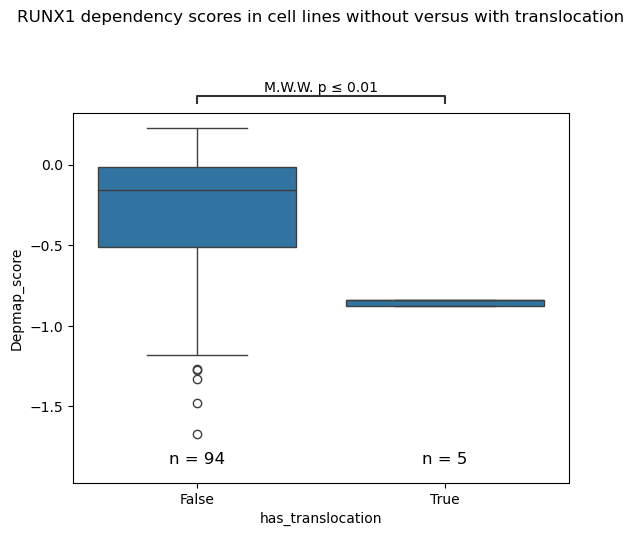

In [142]:
make_boxplot_specific_lineage('RUNX1', 'Lymphoid')

In [162]:
significant_pairs = pd.read_csv("pydata/tf_dependency_e3ls_expr_correlation_bylineage_fdr_significant.csv")

In [163]:
significant_pairs

Unnamed: 0        lineage        TF E3_ligase         p-val      corr  \
0         13965  Biliary Tract     DMRT1    PDZRN3  5.360362e-06  0.678751   
1         13987  Biliary Tract    POU3F4    PDZRN3  7.373695e-08  0.760493   
2         13994  Biliary Tract      TP53    PDZRN3  3.209376e-08  0.773384   
3         26689  Biliary Tract    ZNF221    TRIM26  1.404946e-05 -0.655954   
4         45325  Biliary Tract     DMRT1    KLHL10  6.492342e-07  0.722565   
..          ...            ...       ...       ...           ...       ...   
603     1200646         Uterus     ZNF23    KLHL10  2.196990e-06  0.705633   
604     1202051         Uterus    ZNF880    KLHL41  9.777977e-07 -0.722051   
605     1207148         Uterus     GRHL1      TLE3  1.270553e-05 -0.665828   
606     1210057         Uterus      RBAK    TRIM58  3.175769e-06 -0.697777   
607     1210152         Uterus  ARHGAP35    TRIM58  4.256490e-06 -0.691351   

     TF-class       fdr    log10q             name  
0    Positive  0.045134  1.345500     DMRT1-PDZRN3  
1    Positive  0.001012  2.994961    POU3F4-PDZRN3  
2    Positive  0.000587  3.231287      TP53-PDZRN3  
3    Positive  0.096379  1.016016    ZNF221-TRIM26  
4    Positive  0.007126  2.147155     DMRT1-KLHL10  
..        ...       ...       ...              ...  
603  Positive  0.026698  1.573524     ZNF23-KLHL10  
604  Positive  0.026698  1.573524    ZNF880-KLHL41  
605  Positive  0.085776  1.066632       GRHL1-TLE3  
606  Positive  0.032160  1.492685      RBAK-TRIM58  
607  Positive  0.036946  1.432429  ARHGAP35-TRIM58  

[608 rows x 10 columns]

In [171]:
significant_pairs.lineage.unique()

array(['Biliary Tract', 'Bone', 'Bowel', 'Breast', 'CNS/Brain',
       'Head and Neck', 'Lung', 'Lymphoid', 'Myeloid',
       'Ovary/Fallopian Tube', 'Pancreas', 'Pleura', 'Prostate', 'Skin',
       'Uterus'], dtype=object)

In [173]:
unique_TFs = [tf for tf in significant_pairs.TF.unique() if tf != 'TP53']

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.111e-01 U_stat=3.400e+01


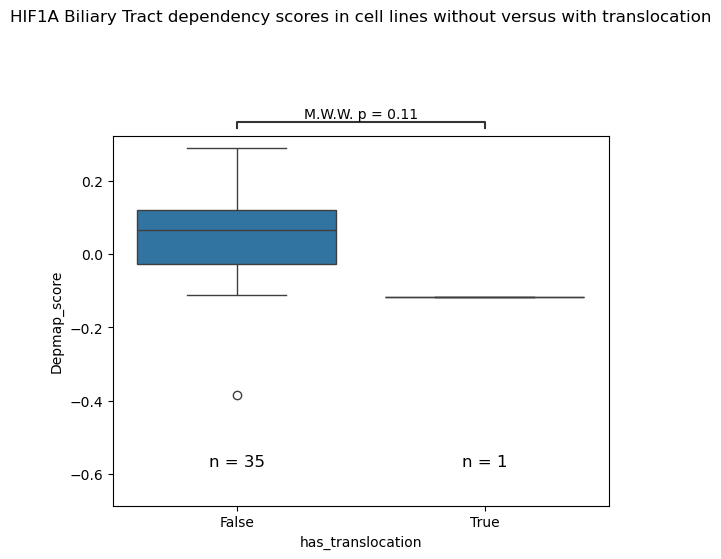

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:5.556e-02 U_stat=3.500e+01


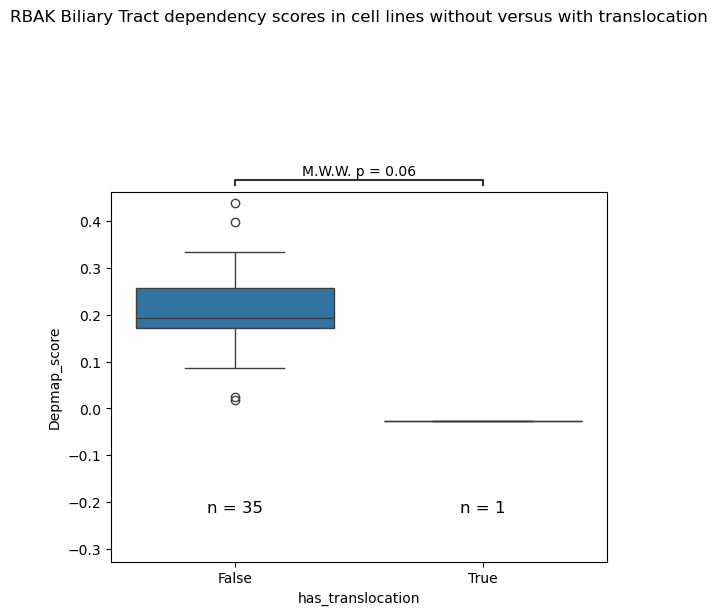

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:2.903e-02 U_stat=2.000e+00


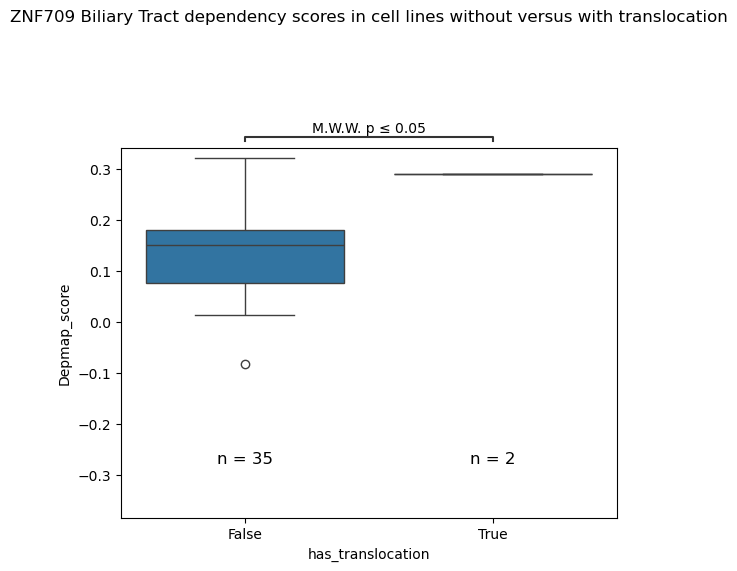

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:9.754e-01 U_stat=9.300e+01


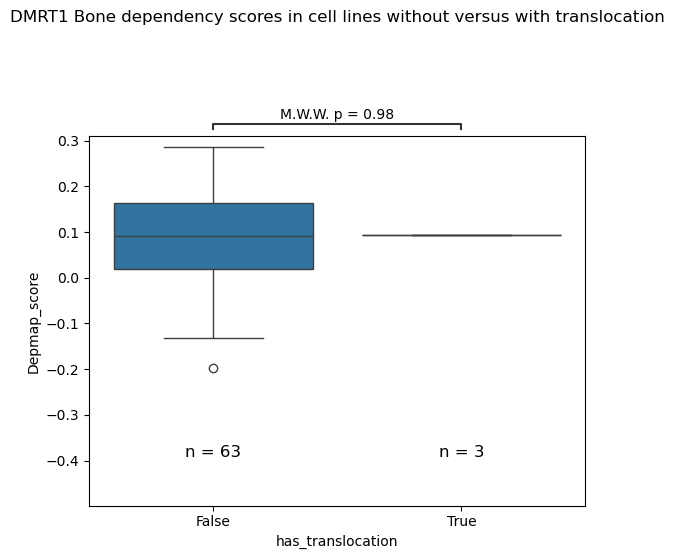

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:8.125e-01 U_stat=2.500e+01


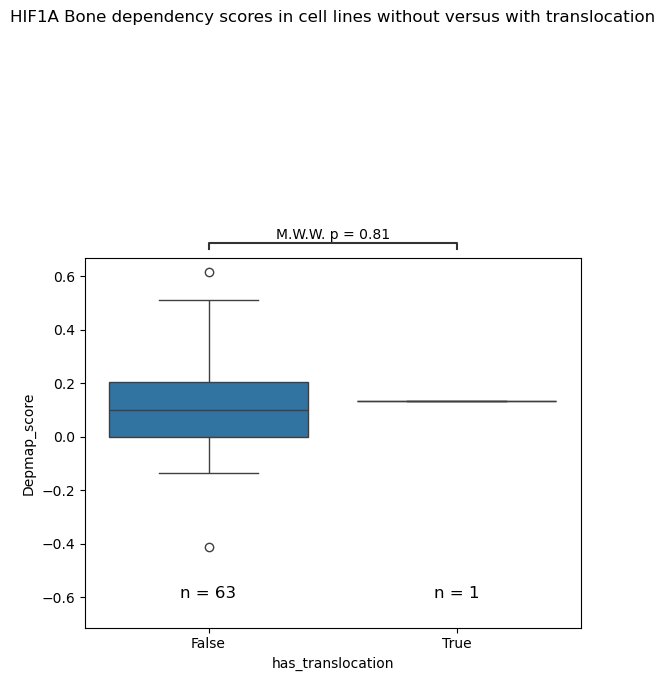

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.562e-01 U_stat=4.000e+00


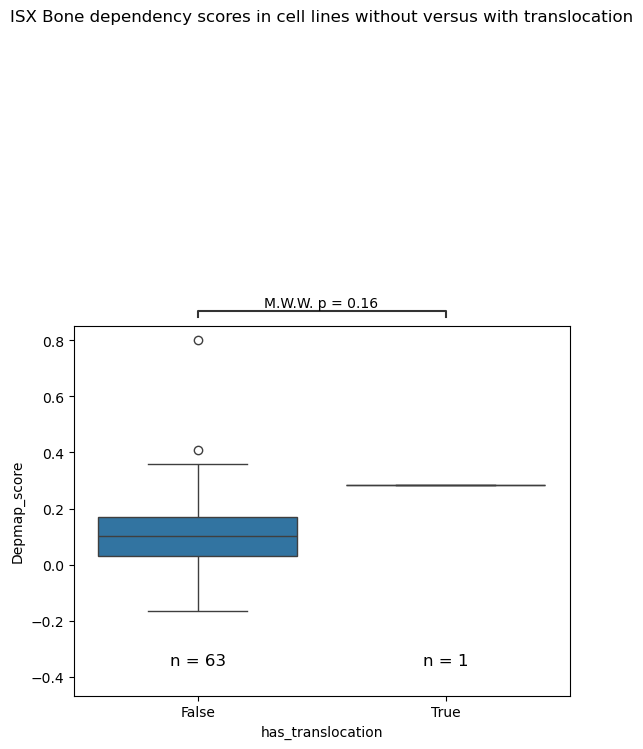

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:5.000e-01 U_stat=1.500e+01


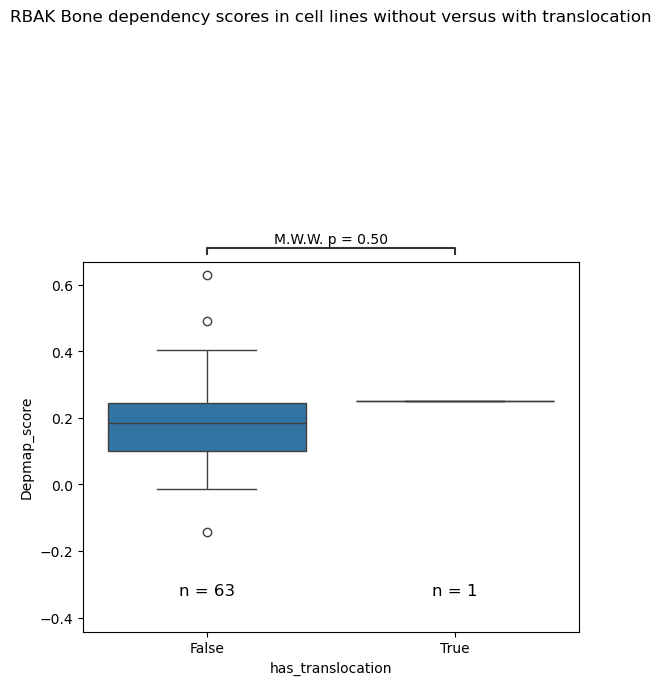

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:2.790e-01 U_stat=3.400e+01


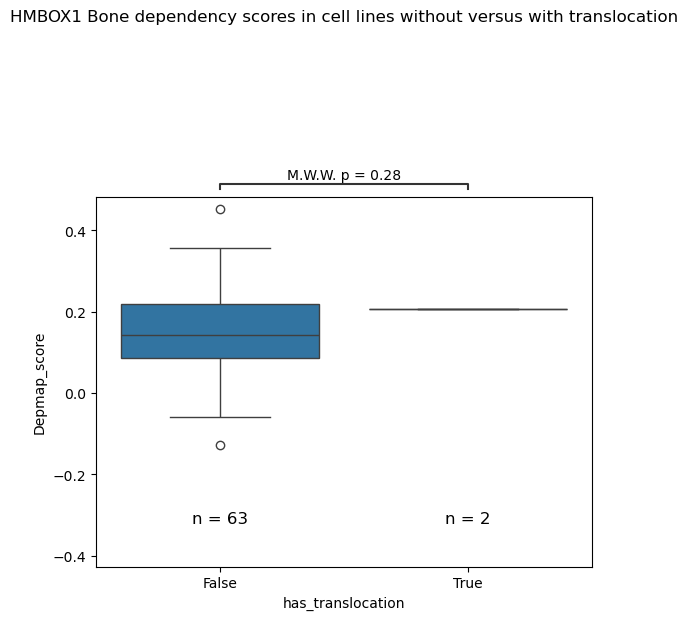

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:3.590e-01 U_stat=1.300e+01


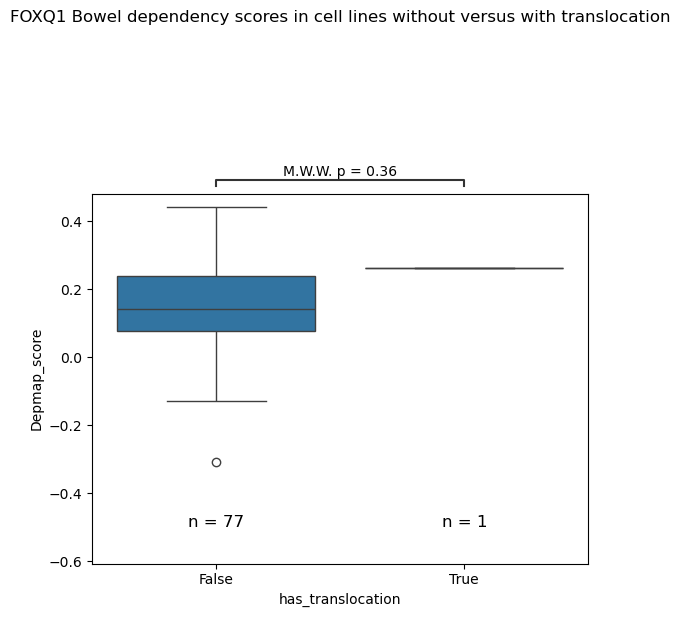

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:4.615e-01 U_stat=1.700e+01


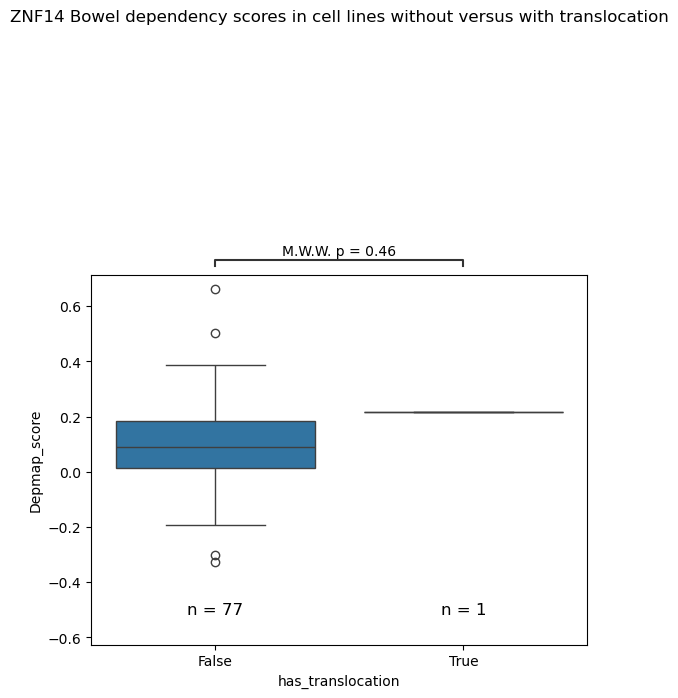

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:6.154e-01 U_stat=5.400e+01


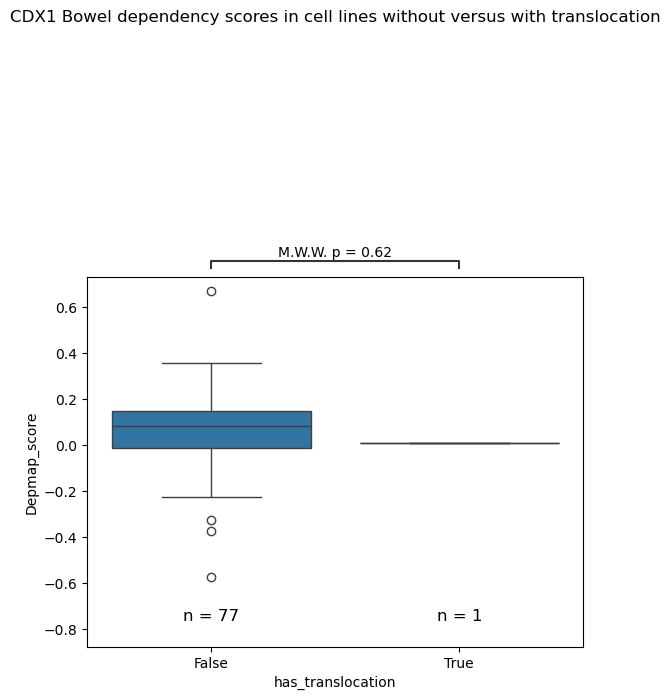

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:6.667e-01 U_stat=5.200e+01


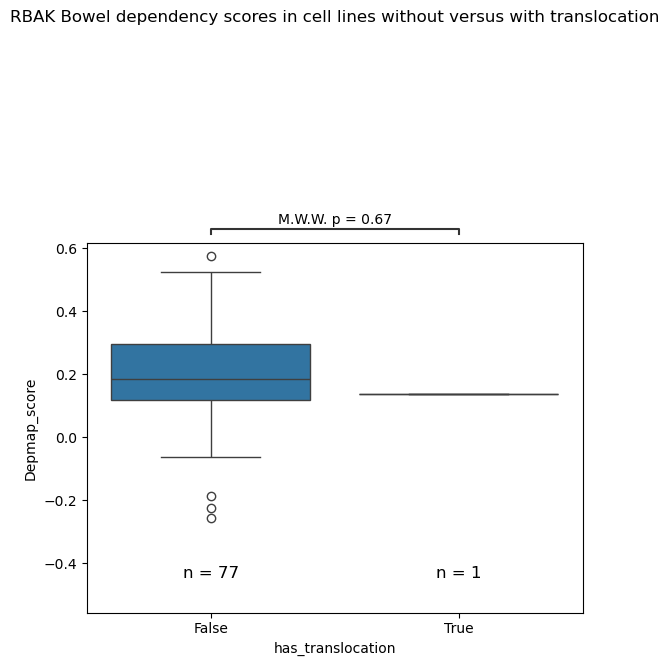

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:6.667e-01 U_stat=2.500e+01


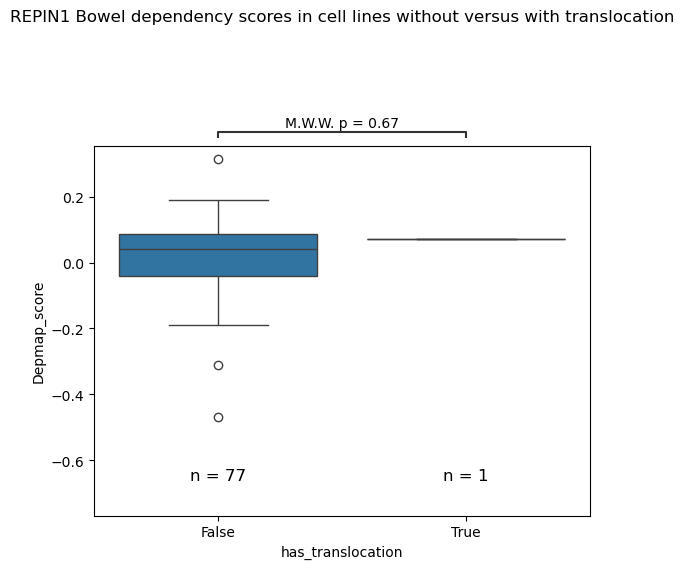

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:7.692e-02 U_stat=2.000e+00


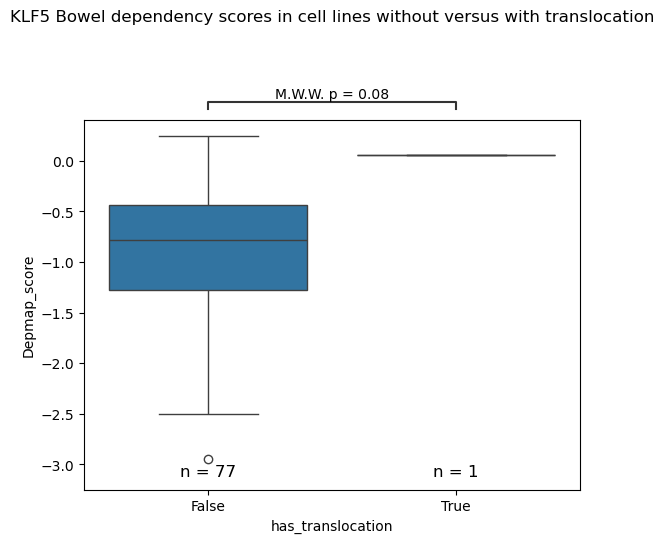

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:7.692e-02 U_stat=7.500e+01


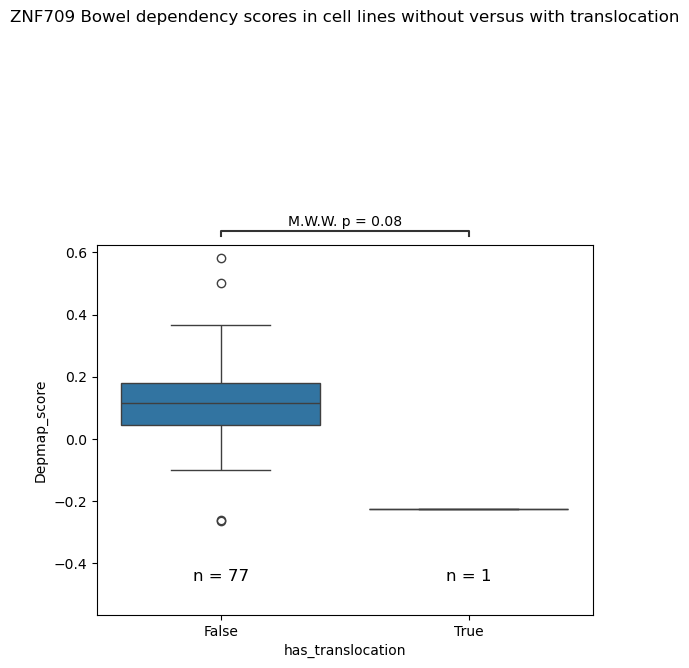

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:5.641e-01 U_stat=5.600e+01


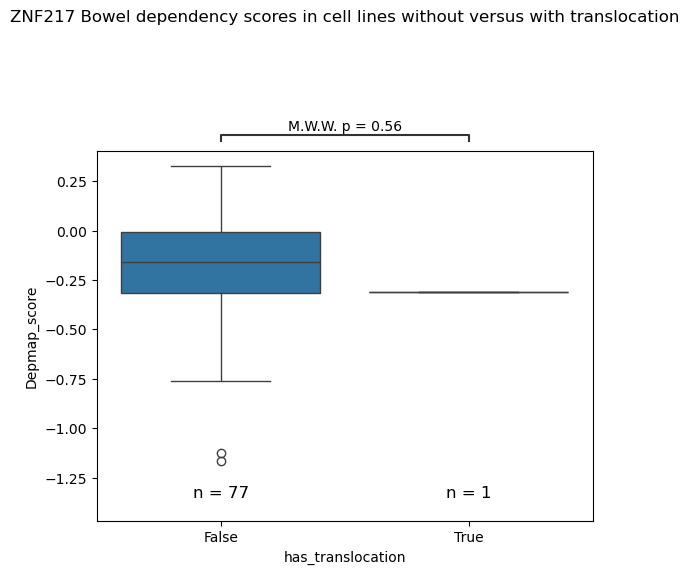

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:7.692e-02 U_stat=7.500e+01


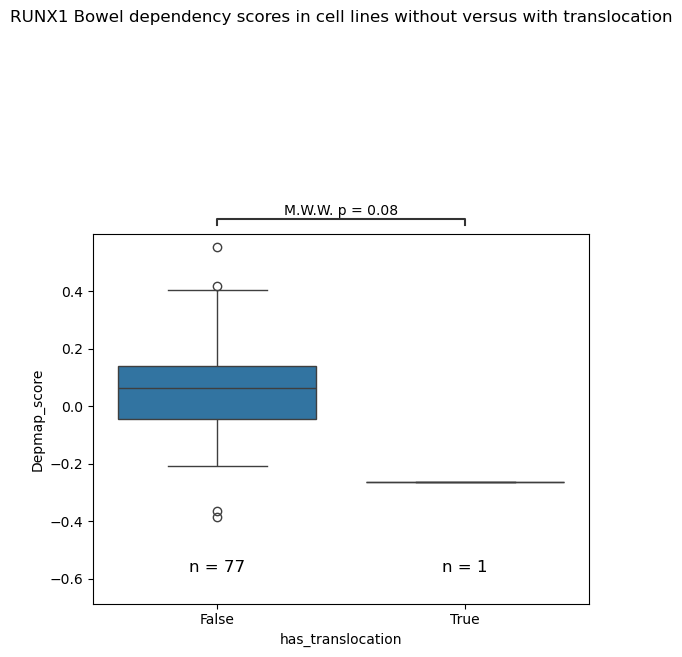

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:9.487e-01 U_stat=4.100e+01


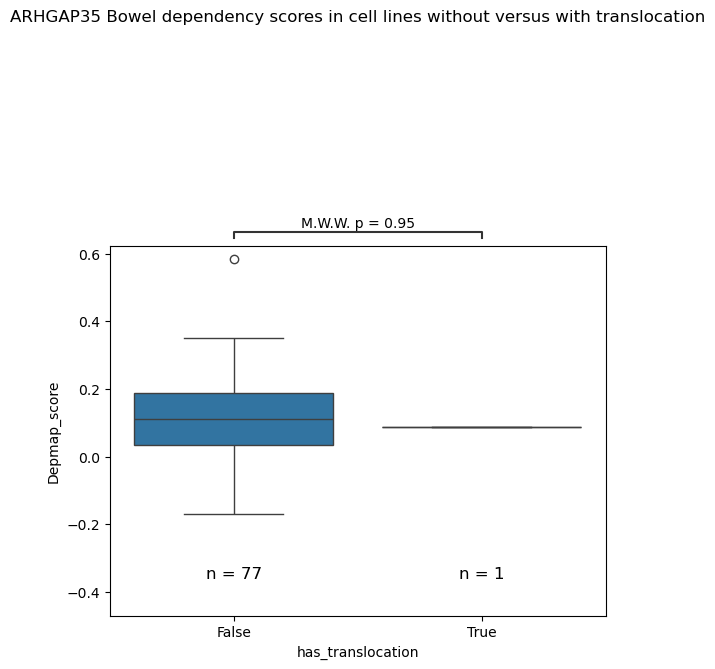

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:3.590e-01 U_stat=1.300e+01


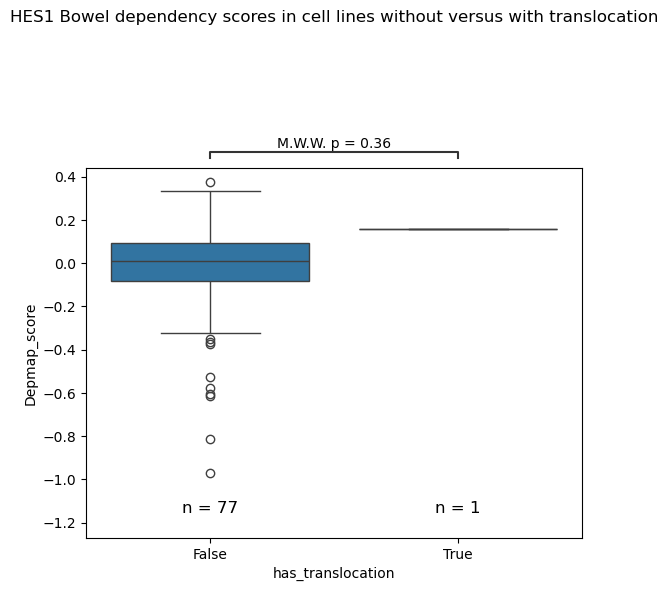

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.212e-01 U_stat=3.000e+00


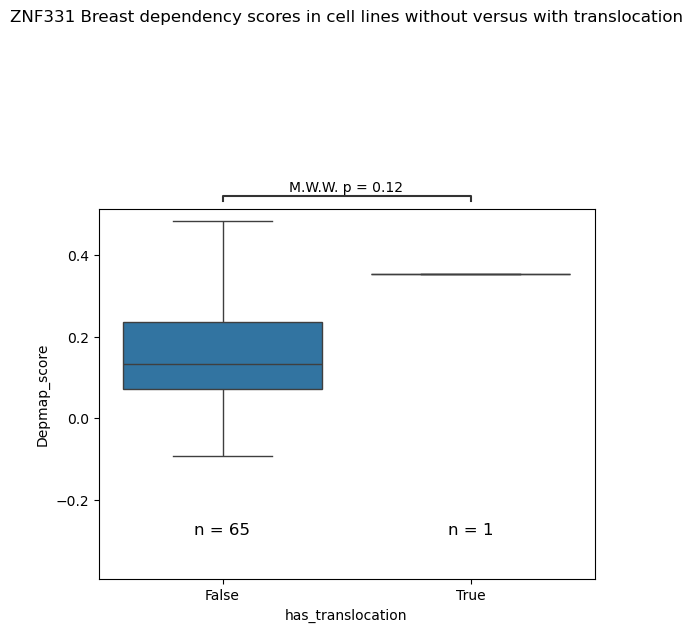

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:7.273e-01 U_stat=4.200e+01


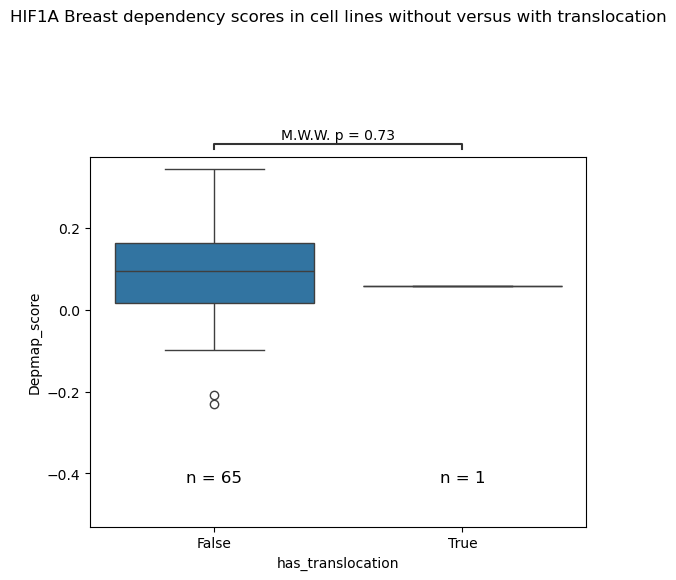

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:4.655e-01 U_stat=1.950e+02


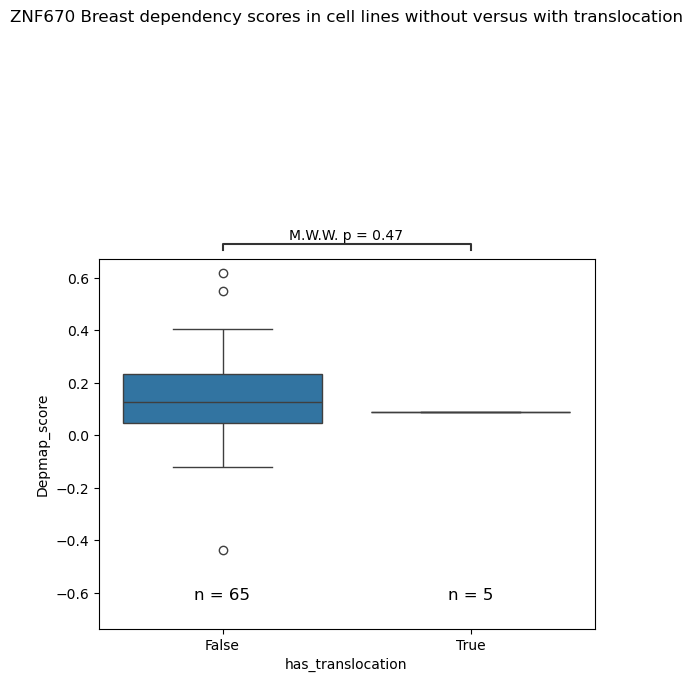

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:4.242e-01 U_stat=1.300e+01


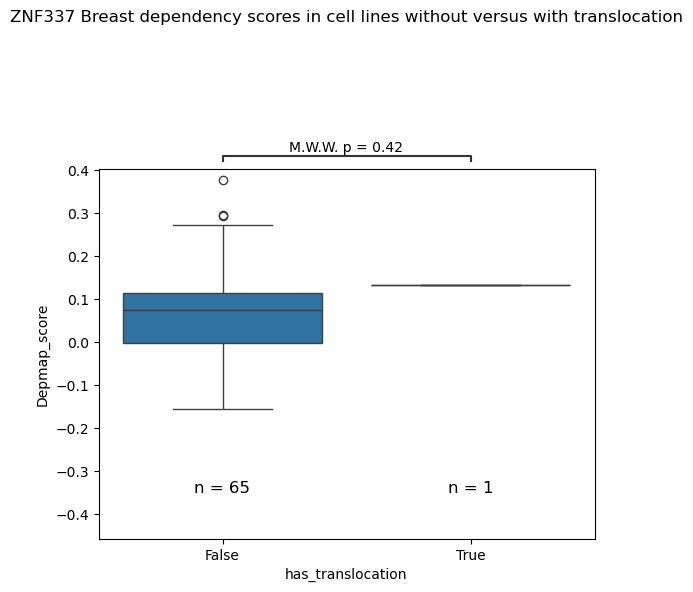

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.515e-01 U_stat=6.100e+01


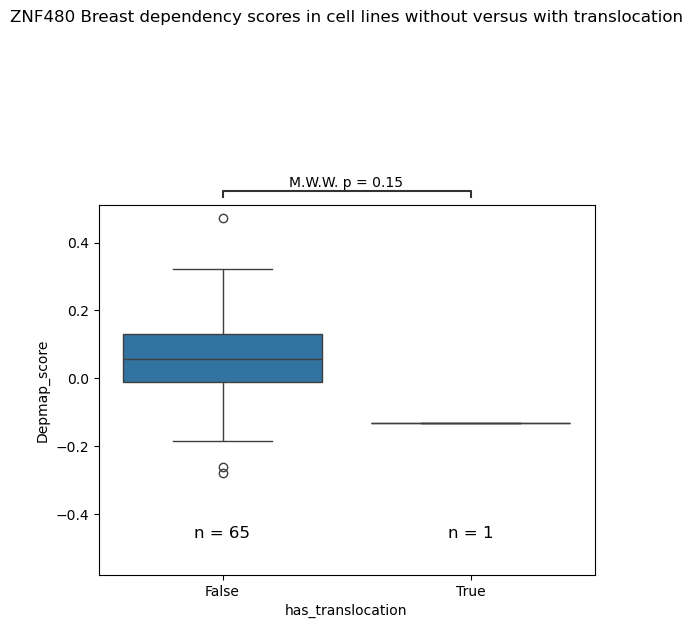

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:8.182e-01 U_stat=2.600e+01


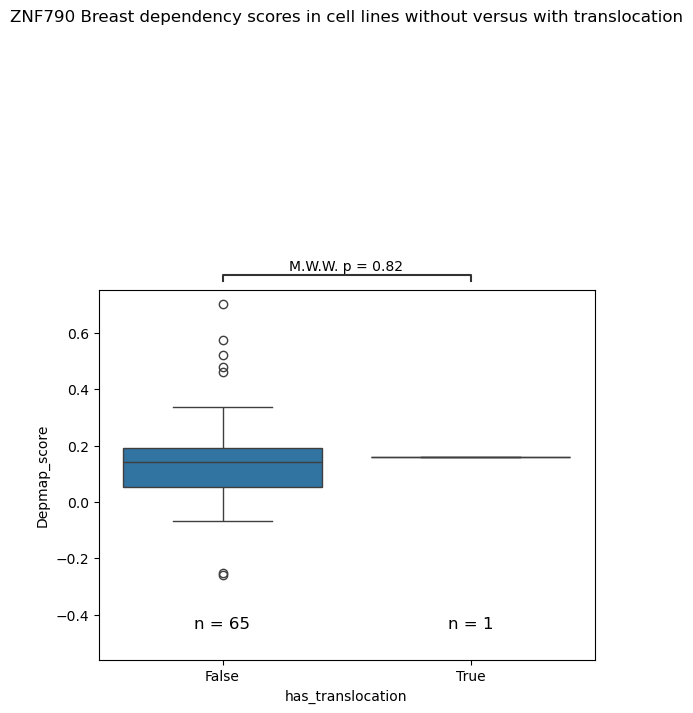

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.818e-01 U_stat=5.000e+00


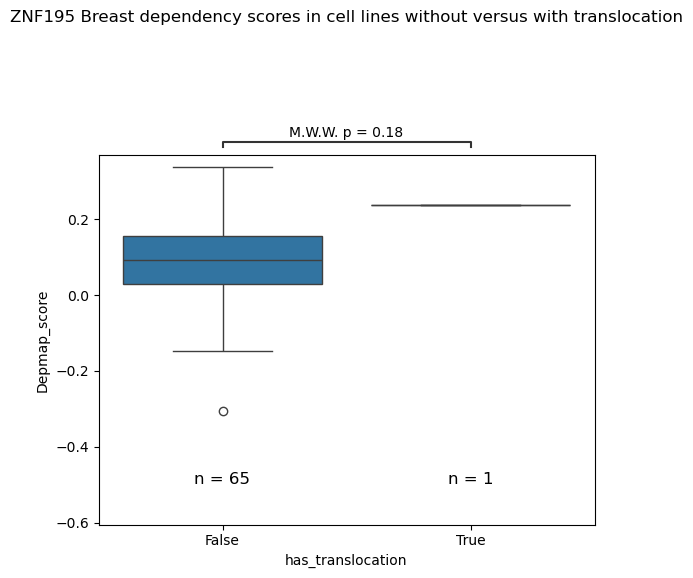

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=3.200e+01


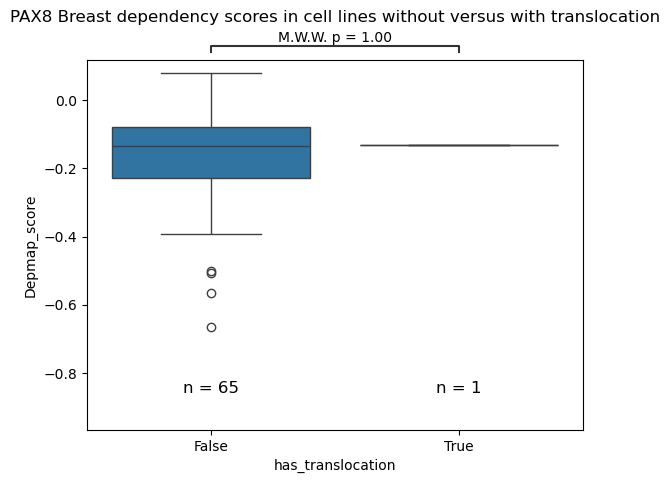

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:7.576e-01 U_stat=4.100e+01


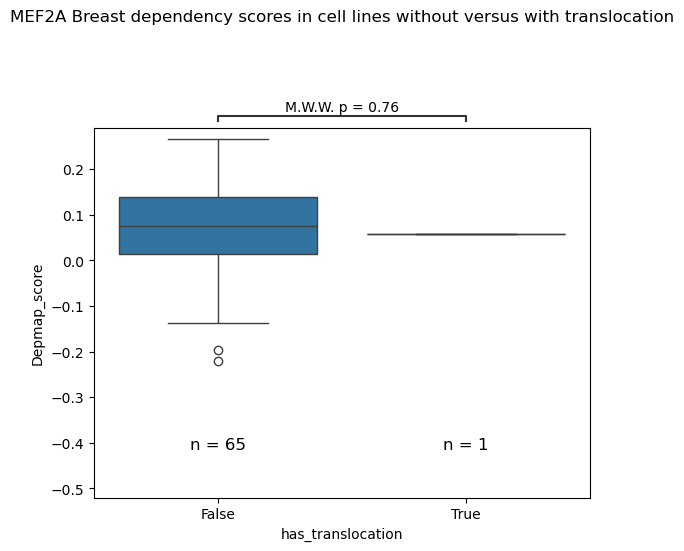

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:2.871e-02 U_stat=2.550e+02


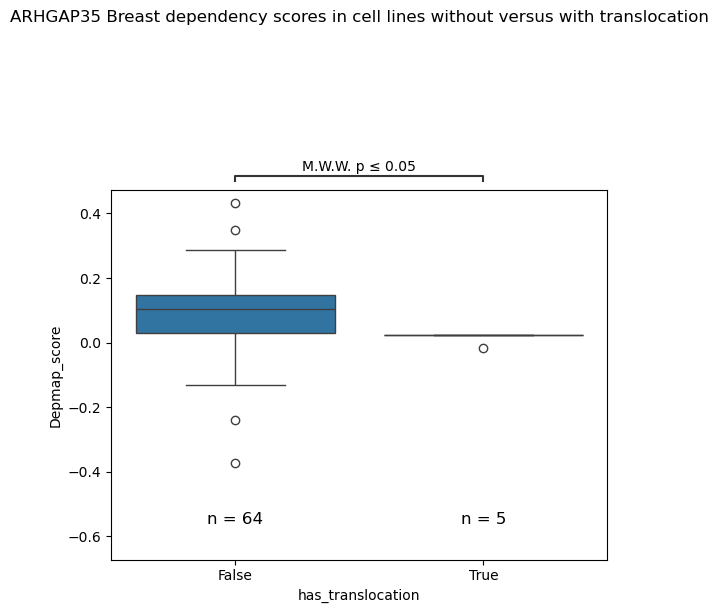

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:6.098e-01 U_stat=1.770e+02


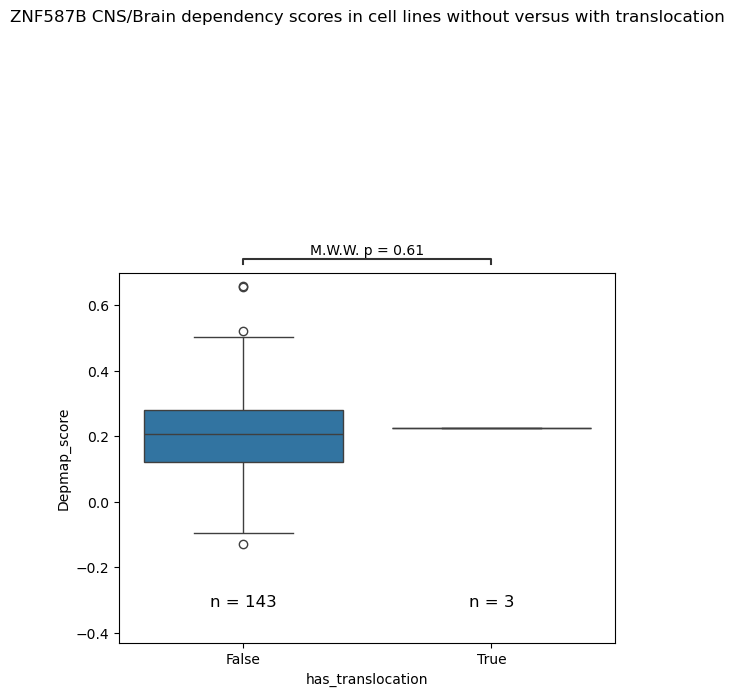

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:2.320e-01 U_stat=2.140e+02


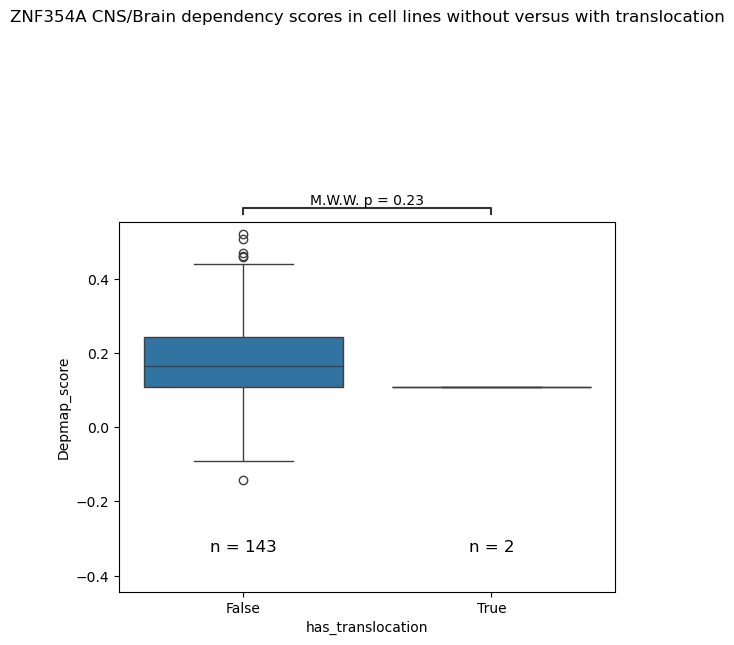

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:4.028e-01 U_stat=2.800e+01


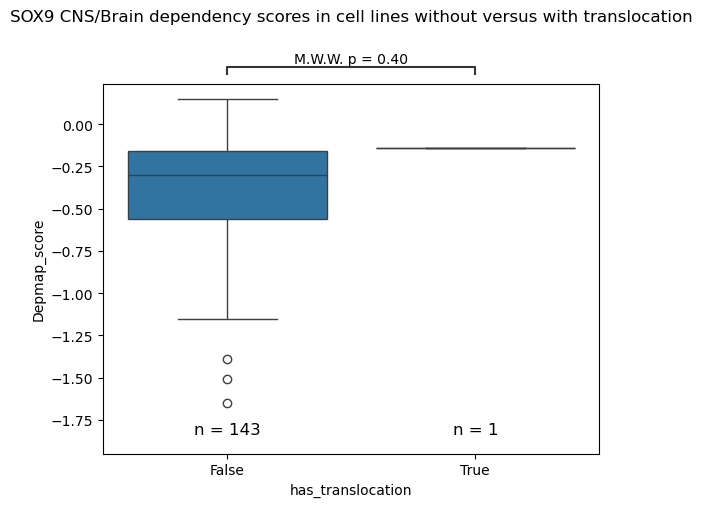

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:9.861e-01 U_stat=7.300e+01


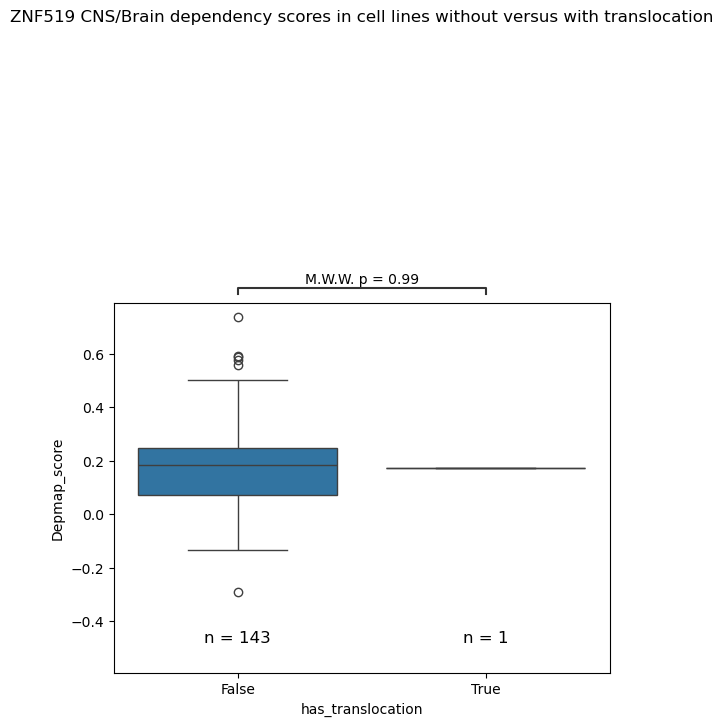

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:5.417e-01 U_stat=3.800e+01


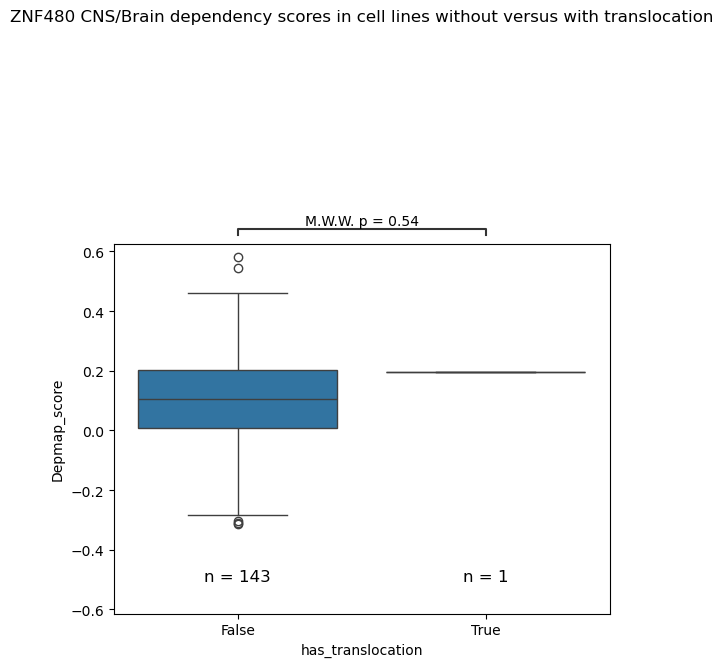

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:4.444e-01 U_stat=3.100e+01


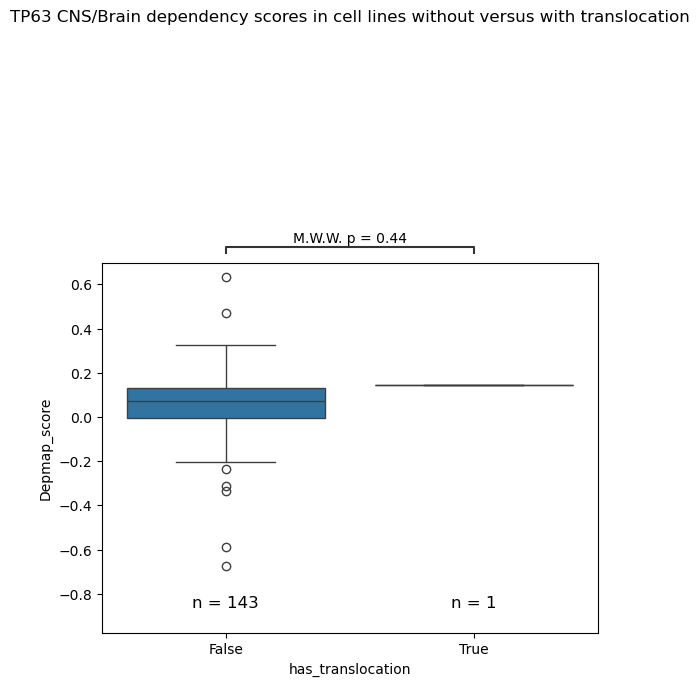

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.570e-02 U_stat=2.860e+02


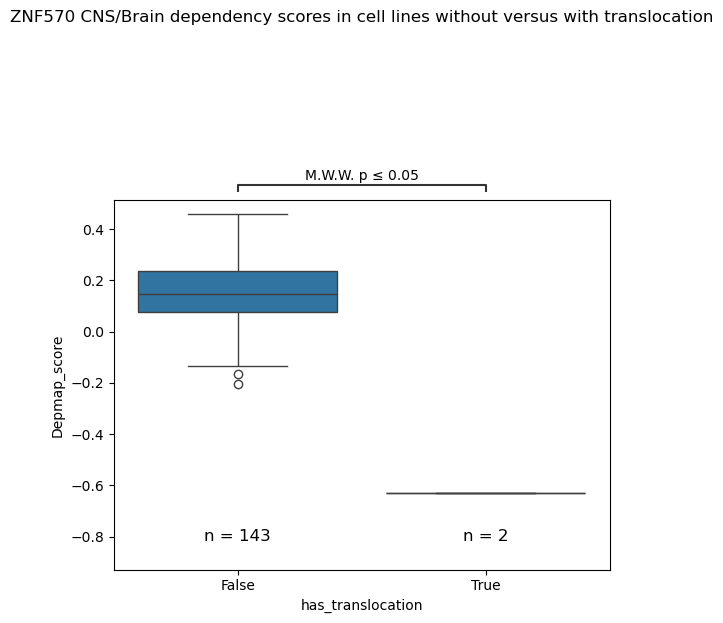

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:5.769e-01 U_stat=1.070e+02


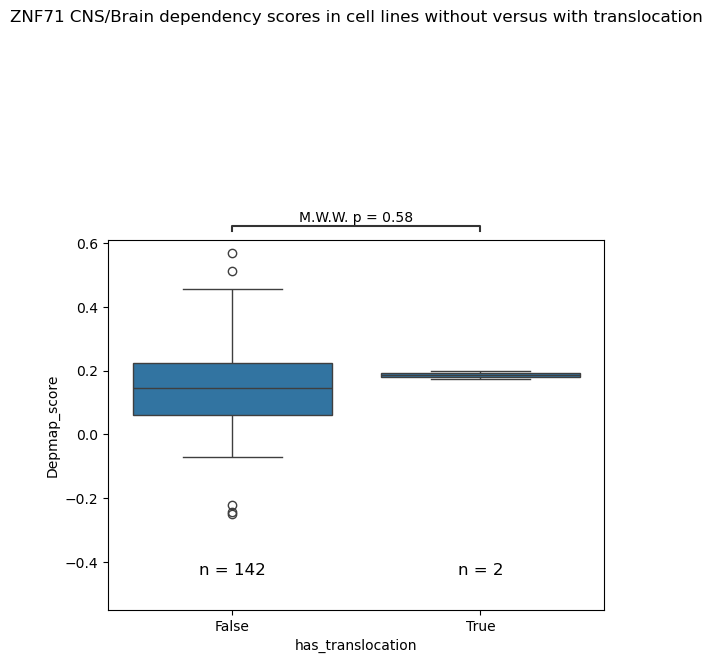

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:8.194e-01 U_stat=5.800e+01


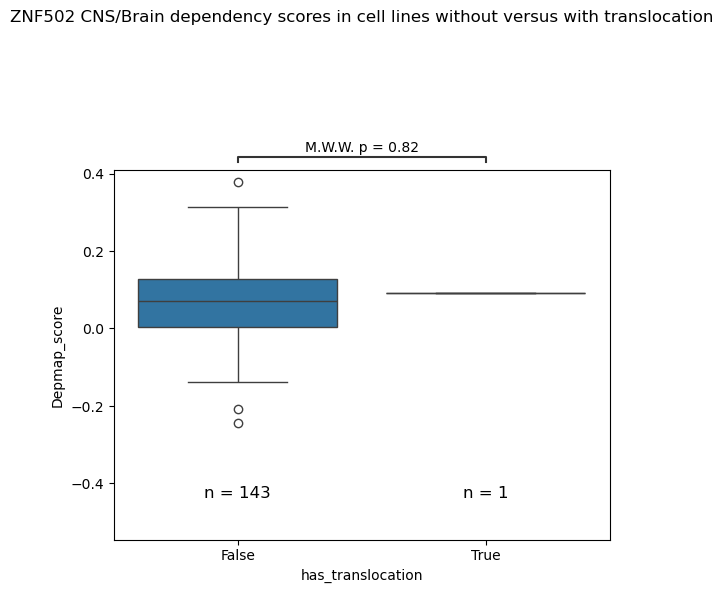

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:7.532e-01 U_stat=4.800e+01


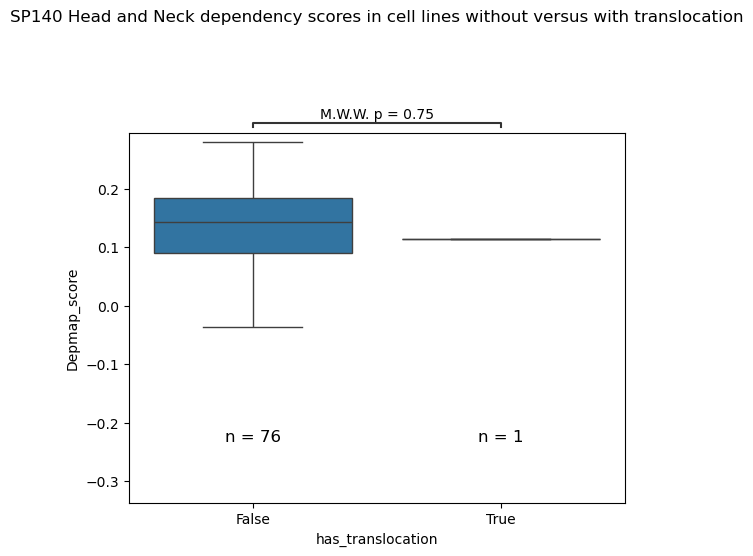

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:4.935e-01 U_stat=5.800e+01


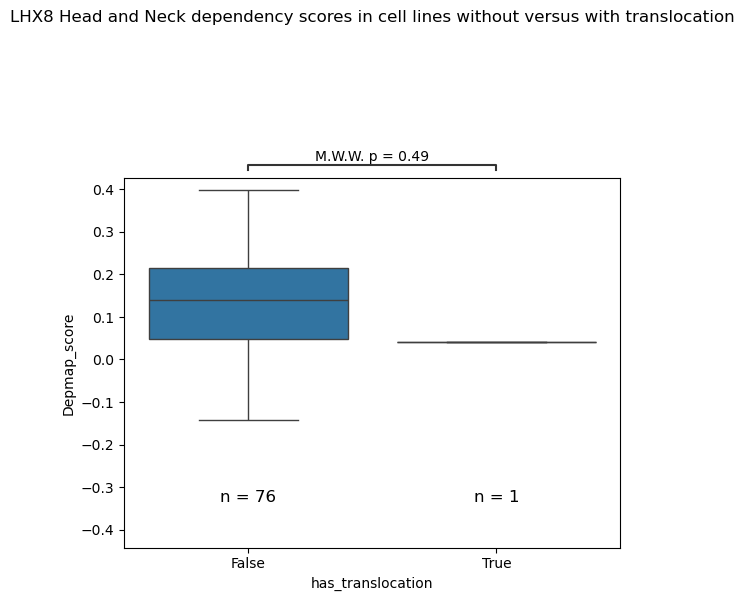

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:2.078e-01 U_stat=6.900e+01


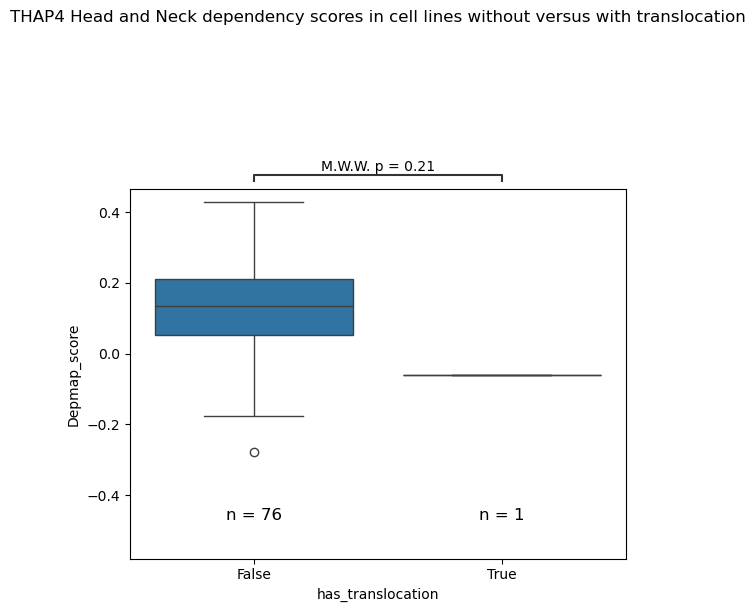

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:6.945e-01 U_stat=2.000e+02


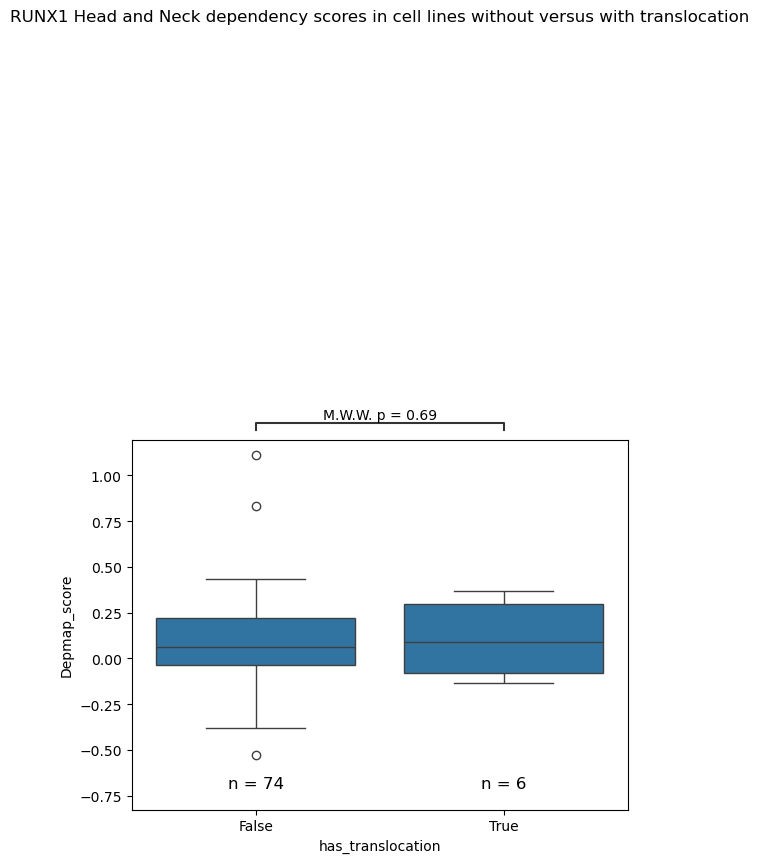

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:2.078e-01 U_stat=7.000e+00


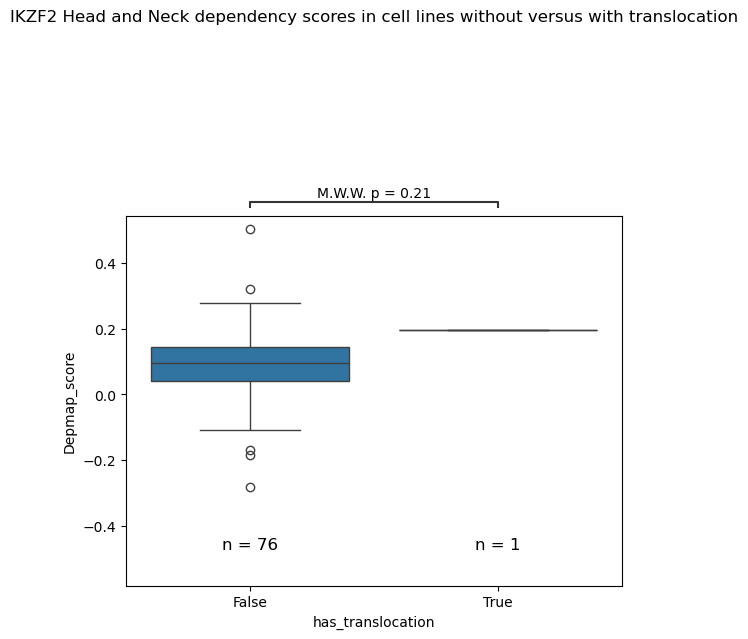

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:9.449e-01 U_stat=5.900e+01


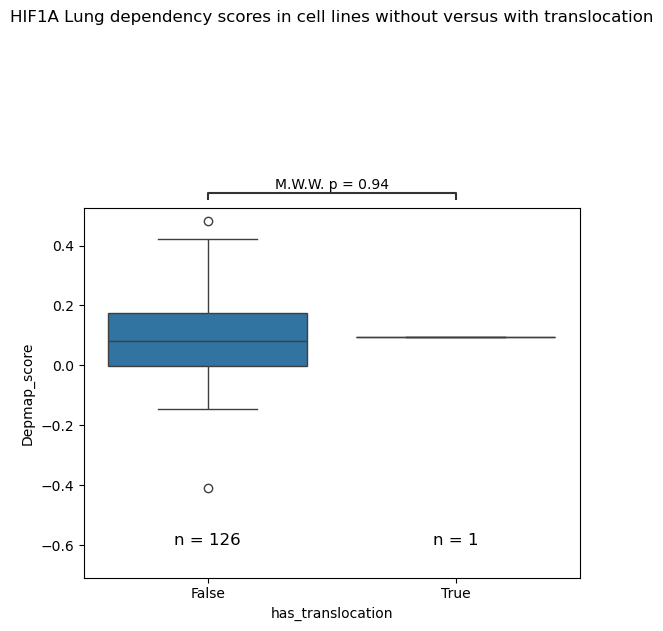

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.815e-02 U_stat=3.700e+01


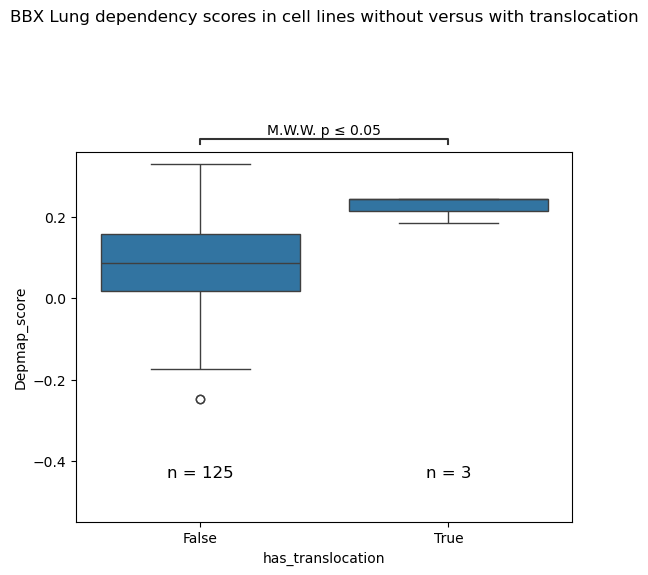

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:8.504e-01 U_stat=7.300e+01


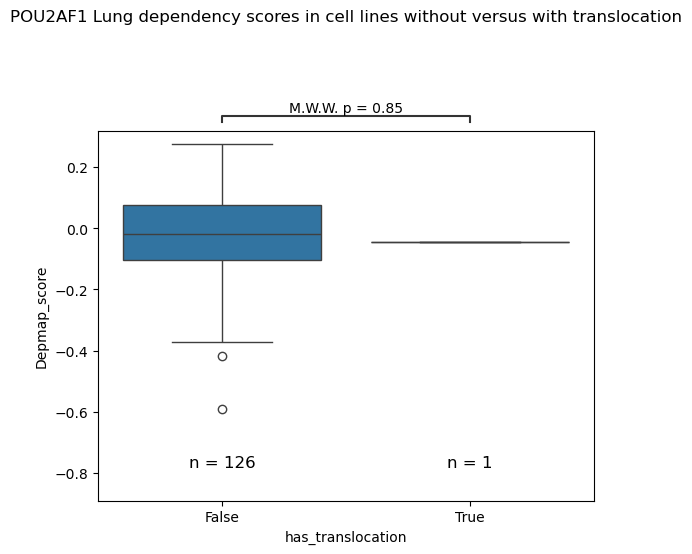

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:7.374e-02 U_stat=3.080e+02


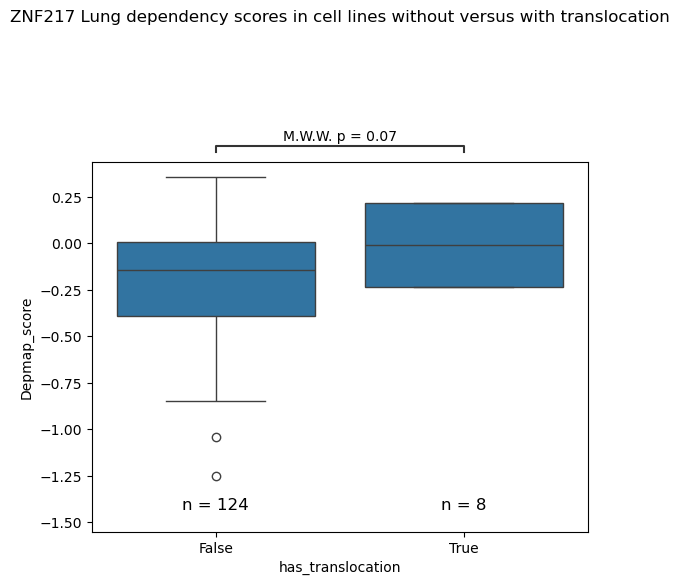

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:7.875e-02 U_stat=2.180e+02


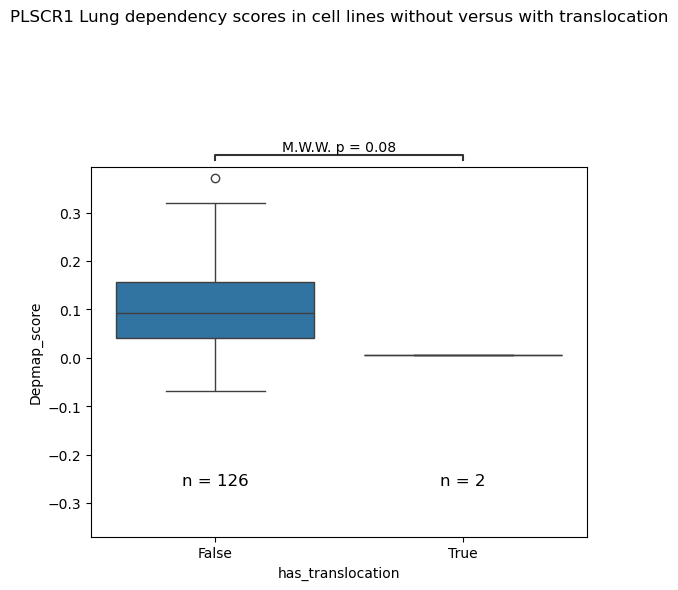

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:4.479e-01 U_stat=8.600e+01


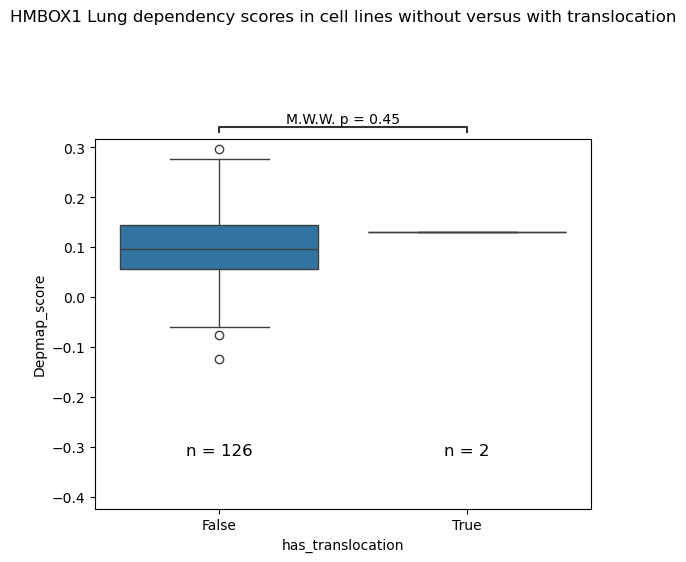

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:5.290e-03 U_stat=7.070e+02


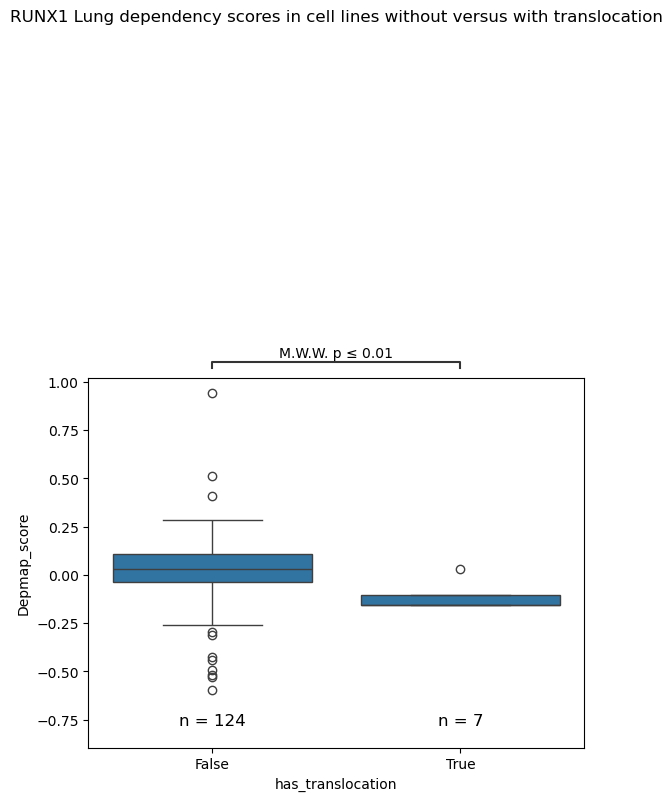

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:9.770e-01 U_stat=1.280e+02


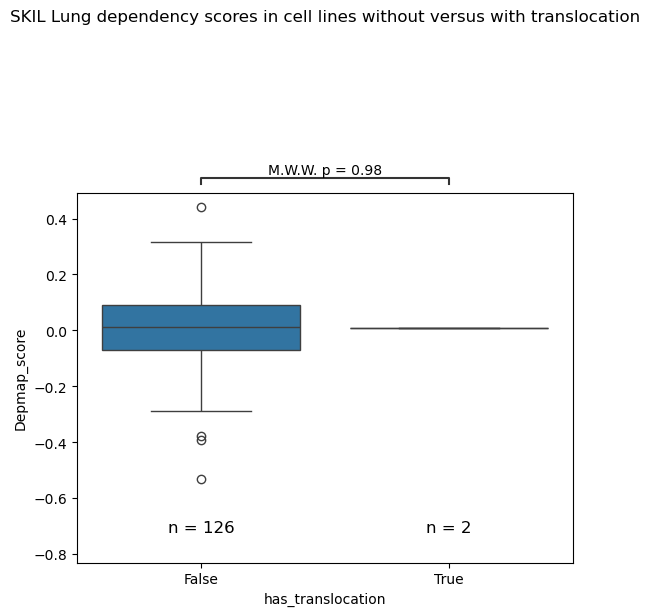

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:5.984e-01 U_stat=3.700e+01


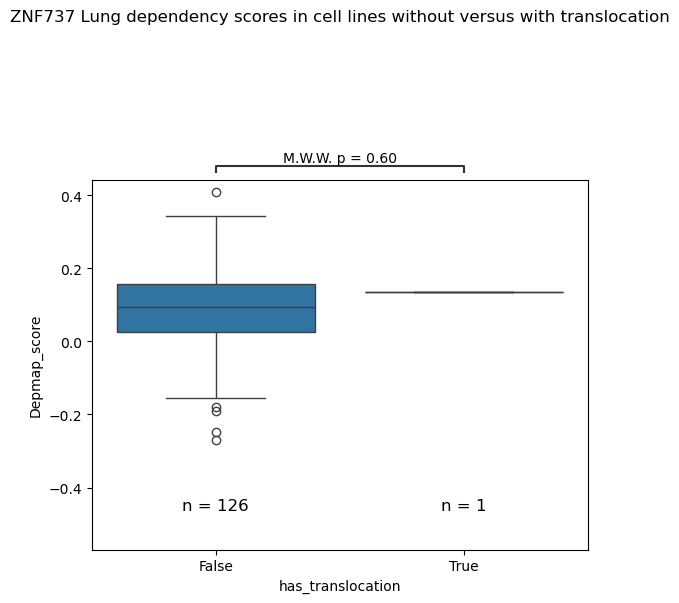

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:2.083e-02 U_stat=9.500e+01


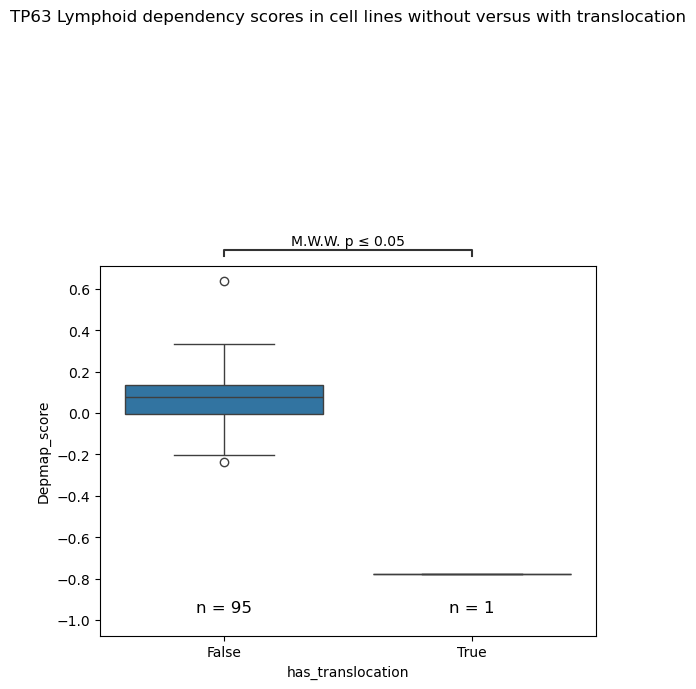

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:6.569e-02 U_stat=1.680e+02


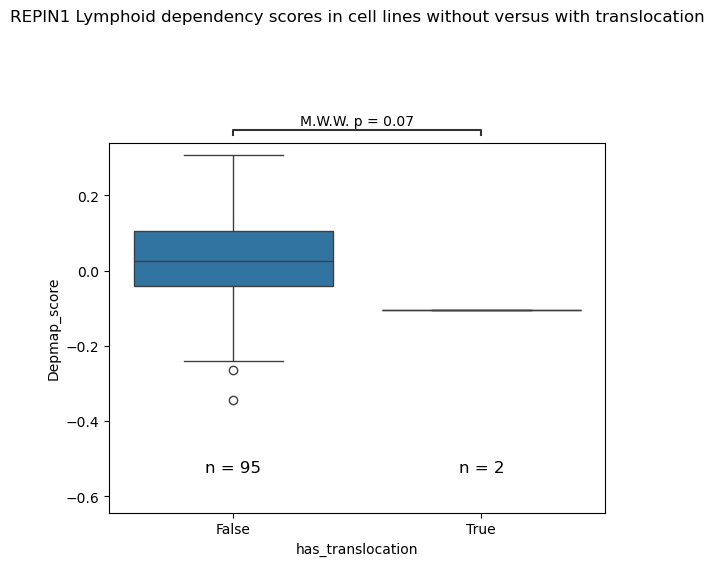

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:8.774e-01 U_stat=1.770e+02


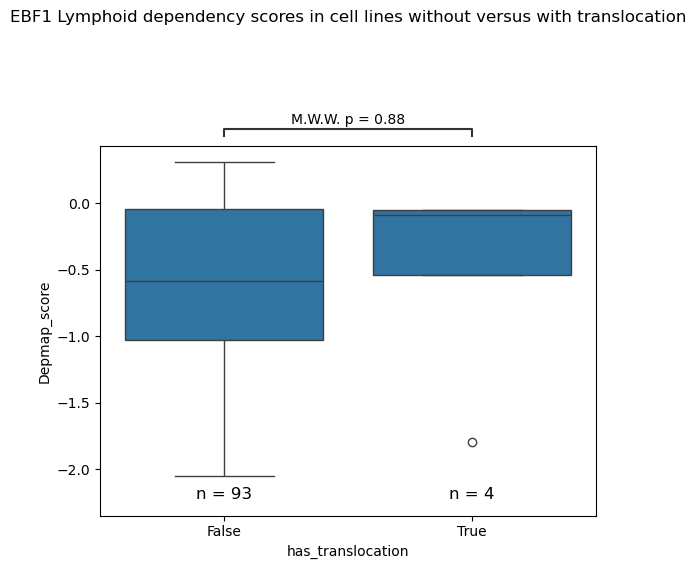

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:4.167e-01 U_stat=7.600e+01


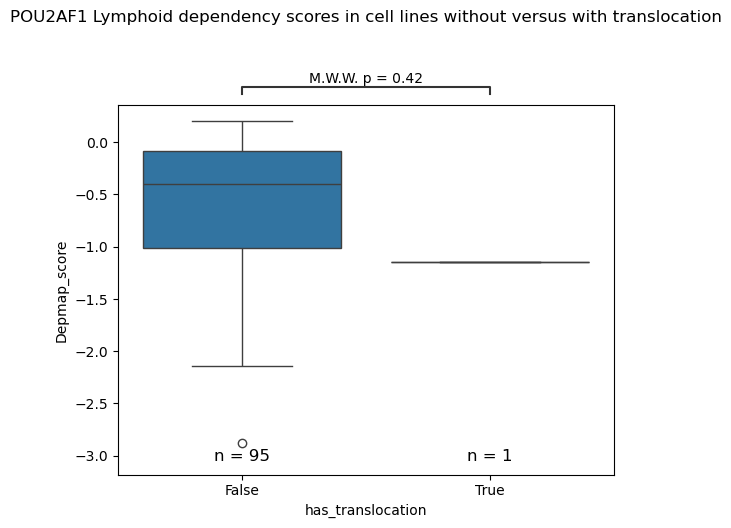

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:3.918e-02 U_stat=2.430e+02


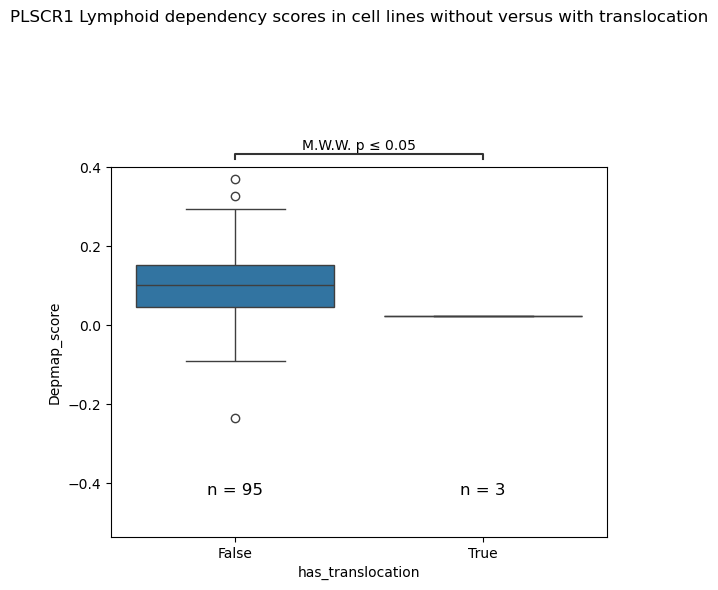

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:7.093e-03 U_stat=4.040e+02


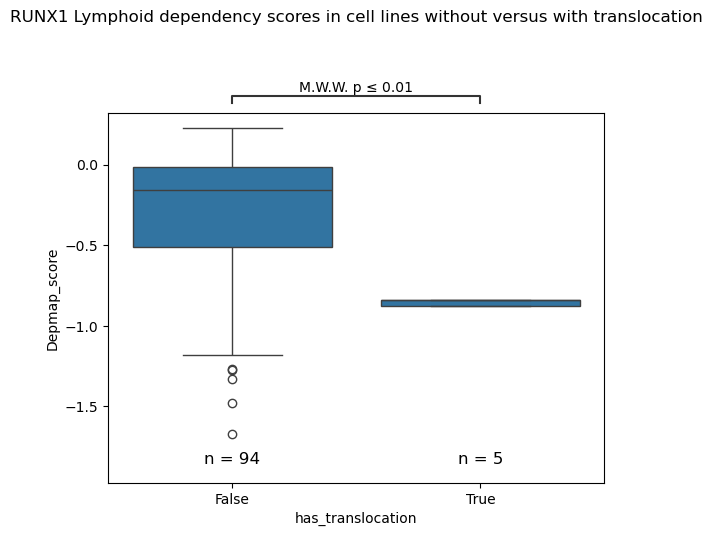

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:5.000e-01 U_stat=2.300e+01


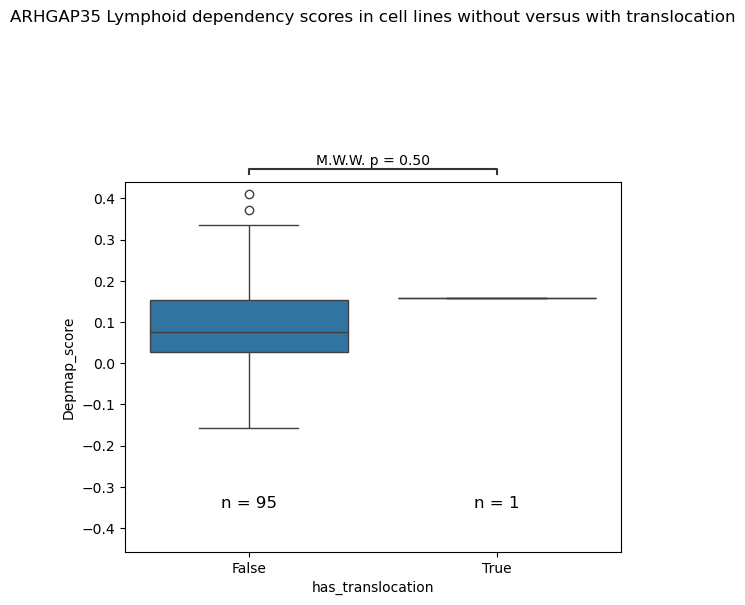

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.042e-01 U_stat=4.000e+00


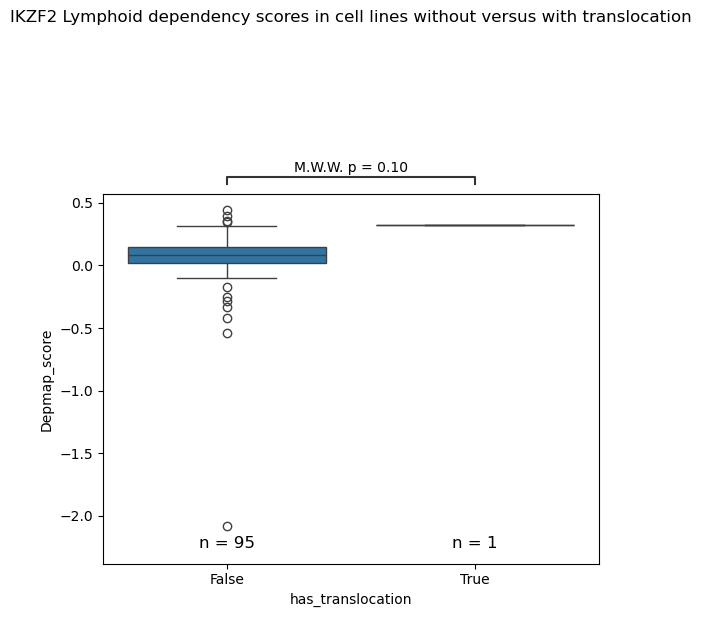

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:8.333e-02 U_stat=4.600e+01


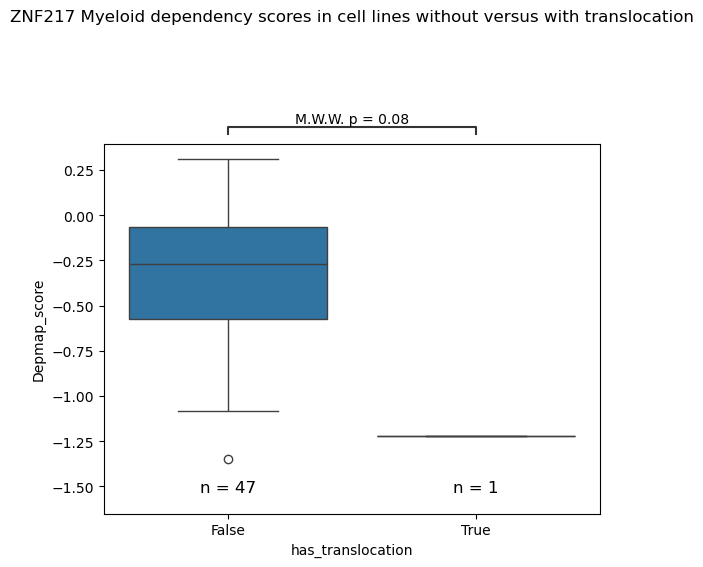

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.207e-01 U_stat=1.330e+02


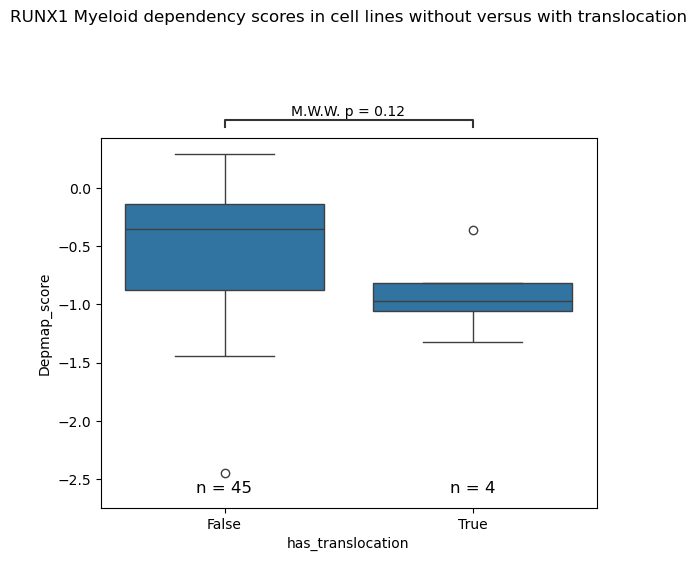

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:4.167e-01 U_stat=3.800e+01


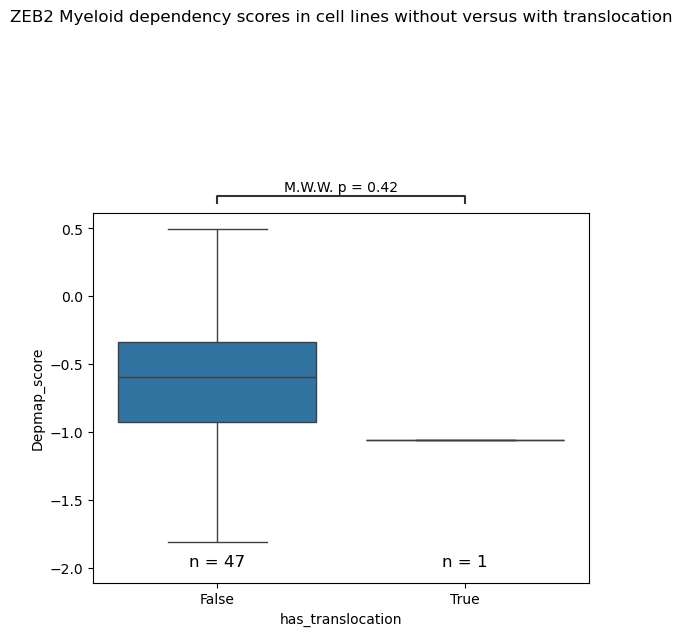

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:5.000e-01 U_stat=1.100e+01


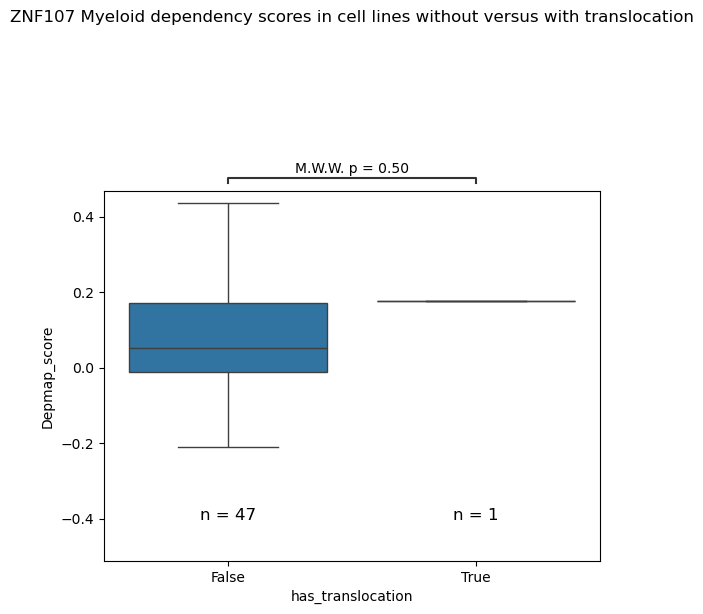

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:6.408e-02 U_stat=1.140e+02


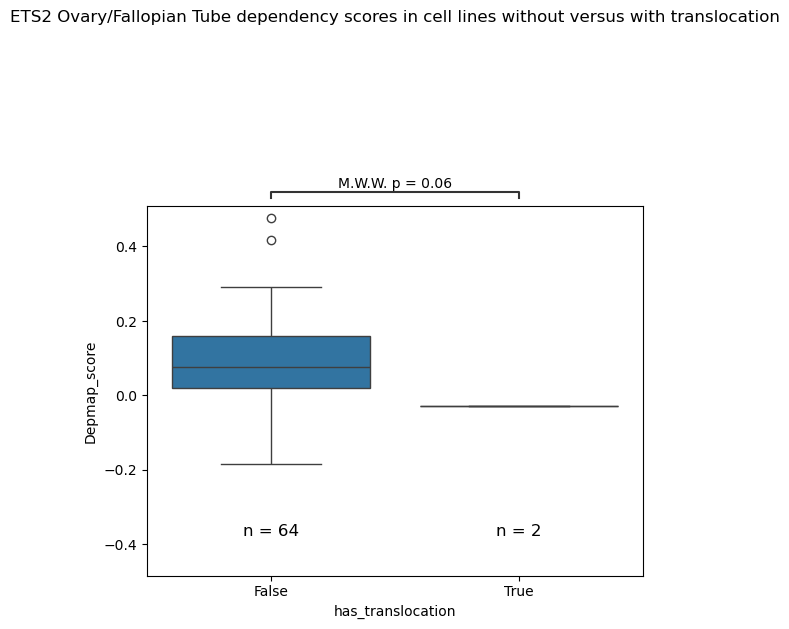

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:6.563e-04 U_stat=1.200e+01


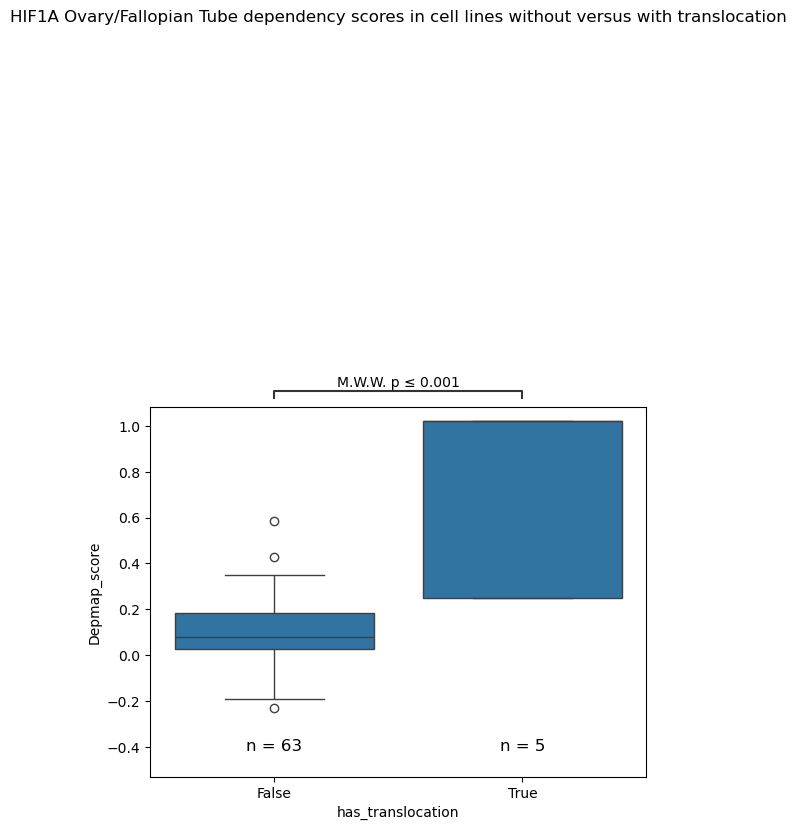

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.538e-01 U_stat=4.000e+00


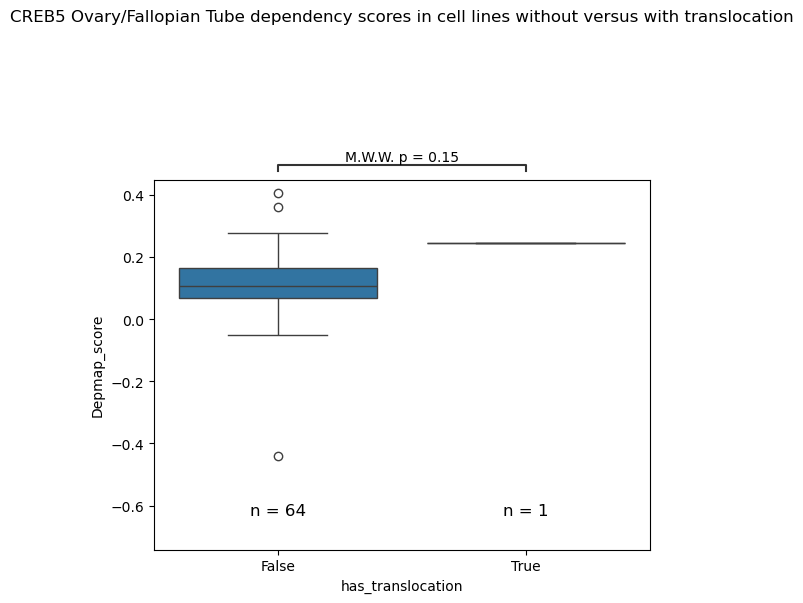

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.795e-01 U_stat=7.600e+01


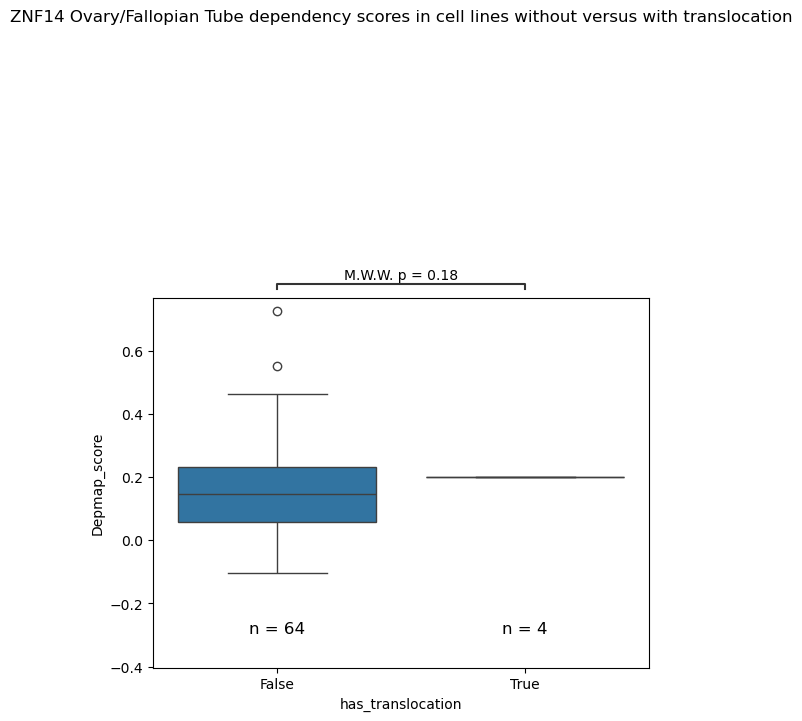

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:8.403e-01 U_stat=1.320e+02


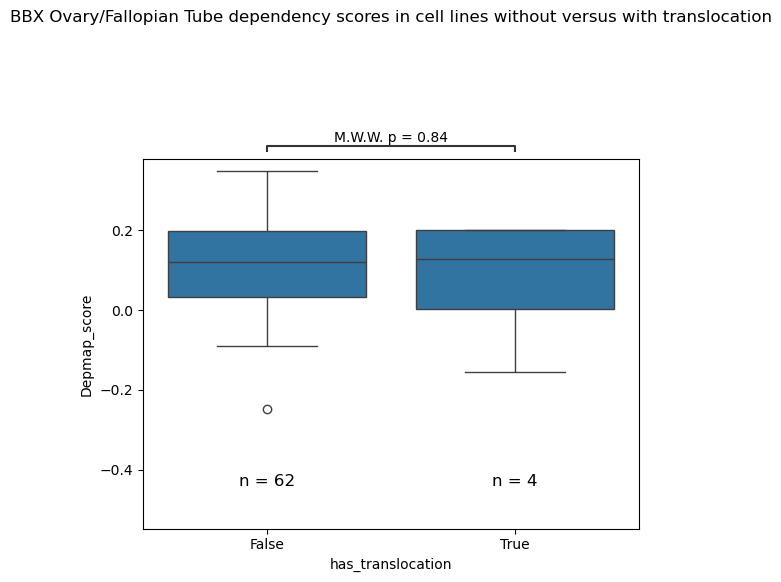

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:7.077e-01 U_stat=4.200e+01


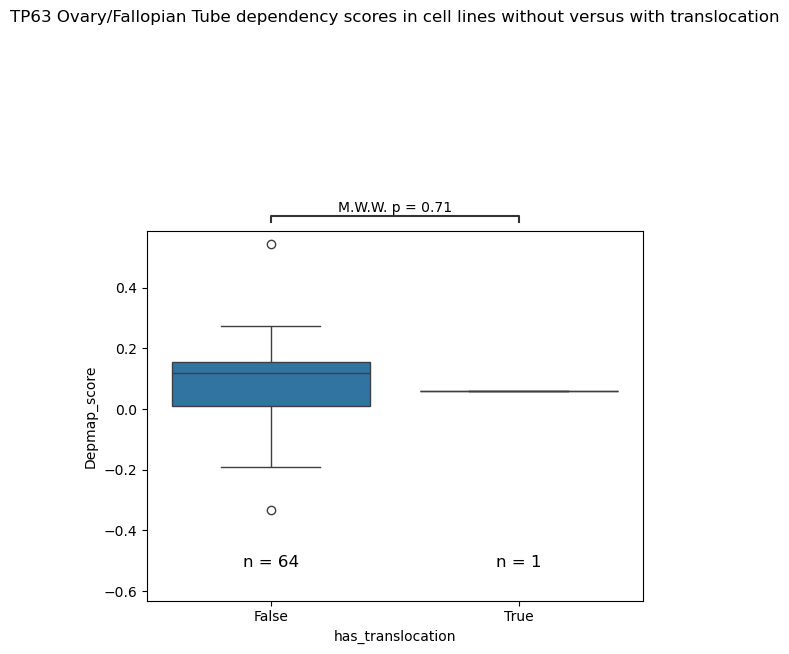

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:8.923e-01 U_stat=2.800e+01


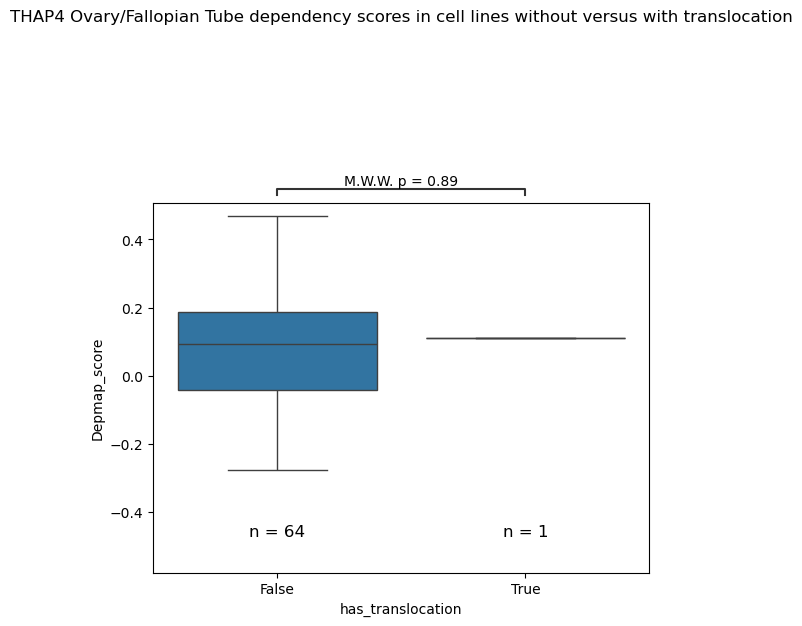

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:9.231e-01 U_stat=2.900e+01


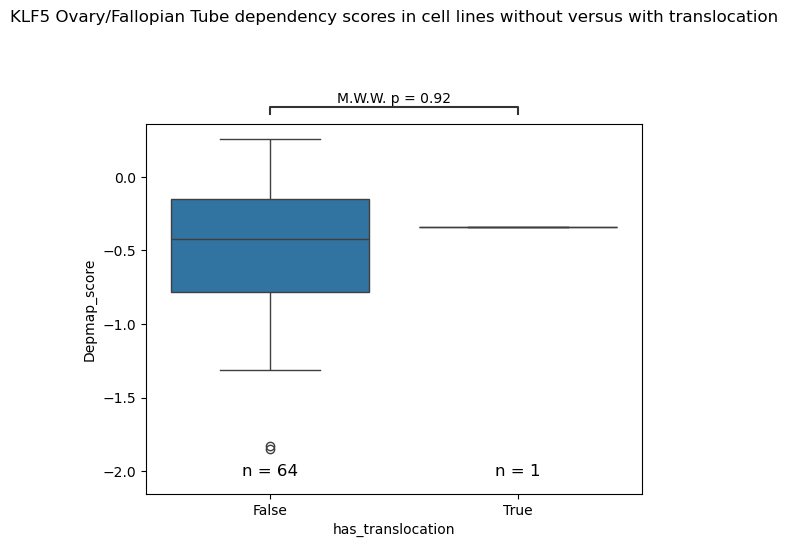

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:5.538e-01 U_stat=1.700e+01


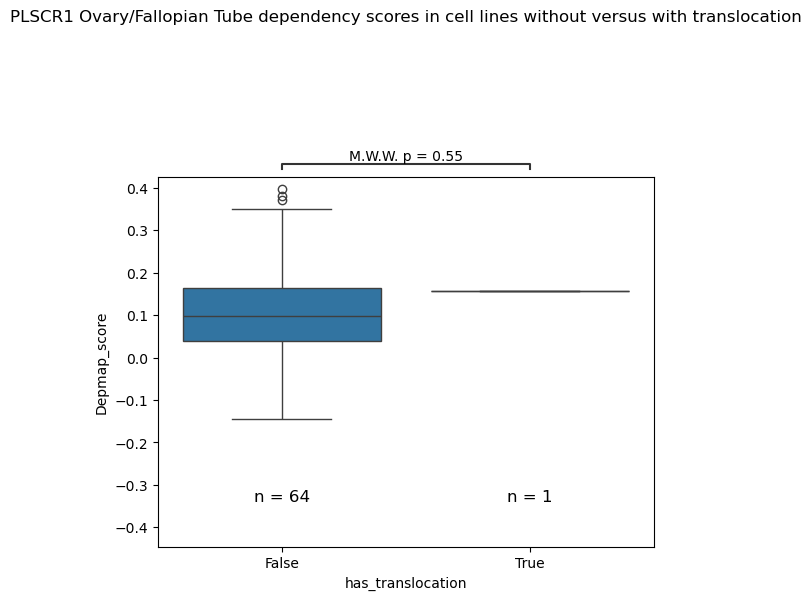

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:3.077e-01 U_stat=5.500e+01


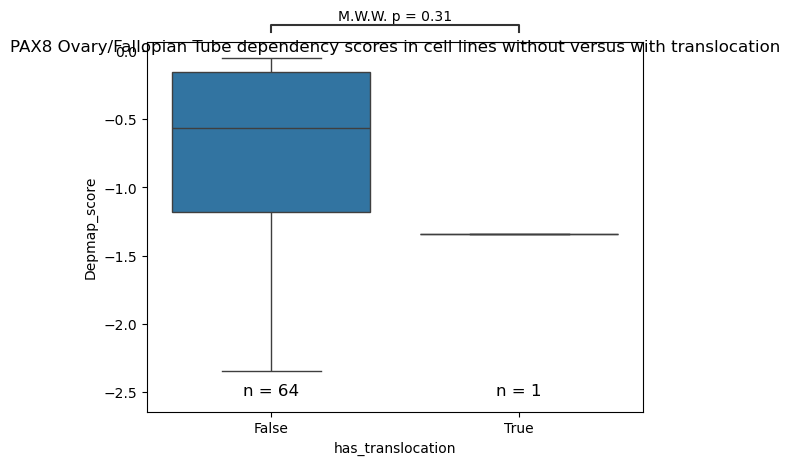

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:6.377e-01 U_stat=2.100e+01


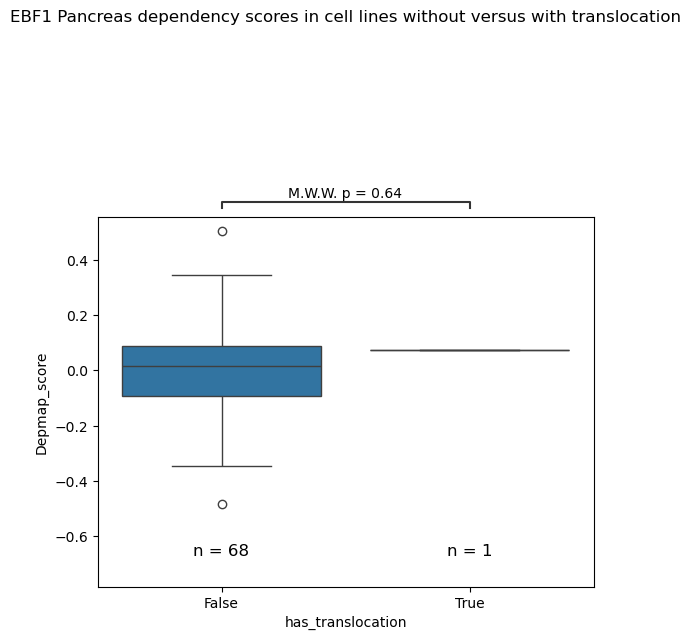

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:8.696e-02 U_stat=2.000e+00


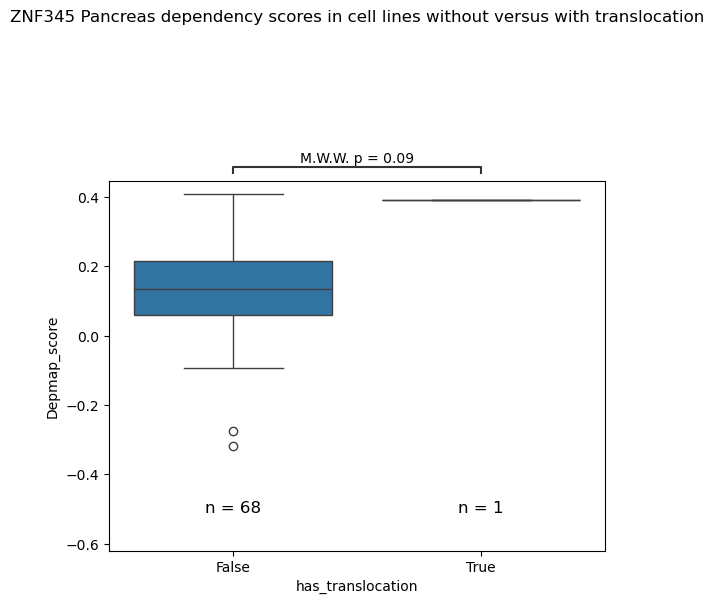

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:2.857e-01 U_stat=1.800e+01


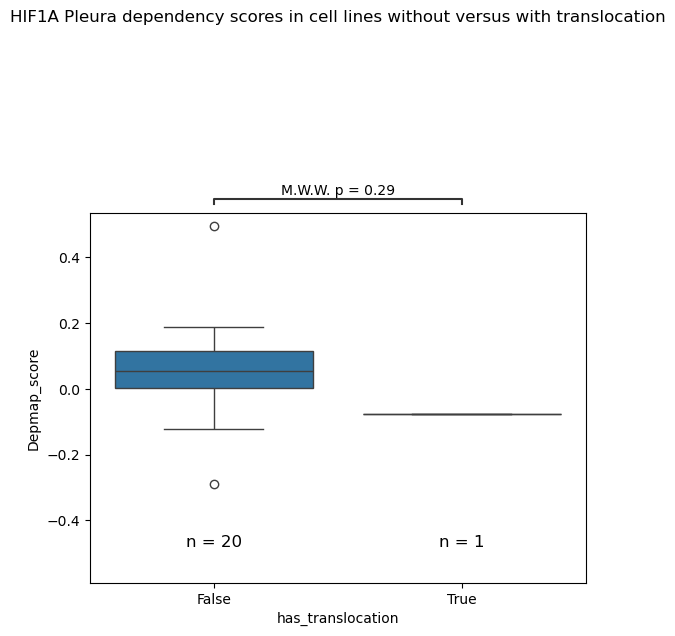

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.836e-01 U_stat=3.000e+01


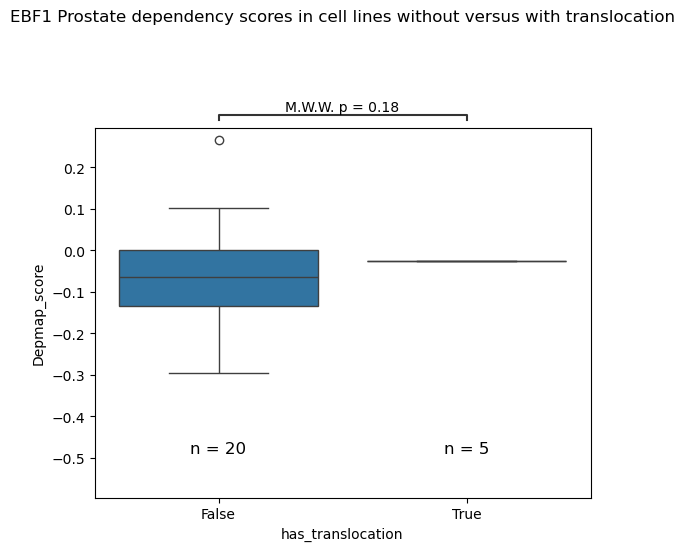

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:6.390e-02 U_stat=1.670e+02


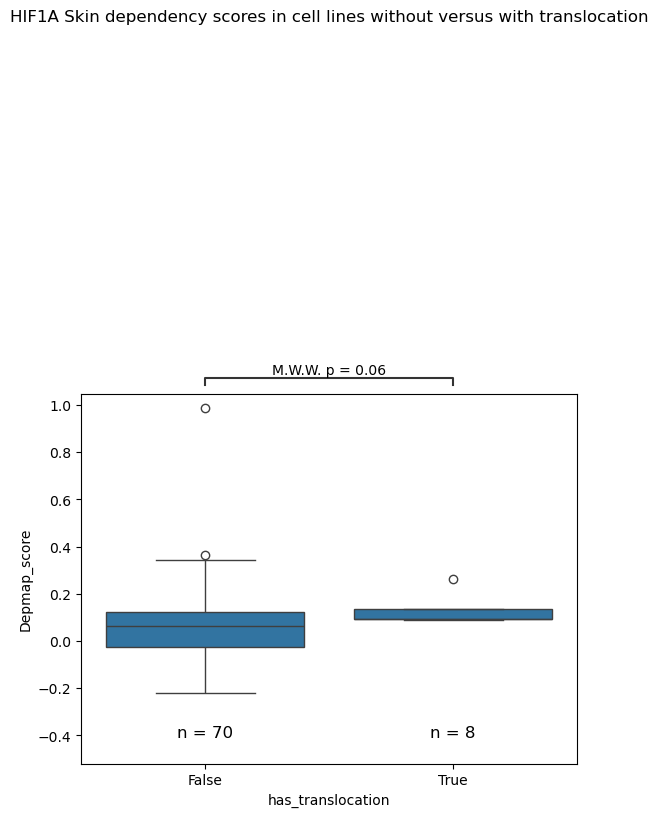

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:2.162e-01 U_stat=6.600e+01


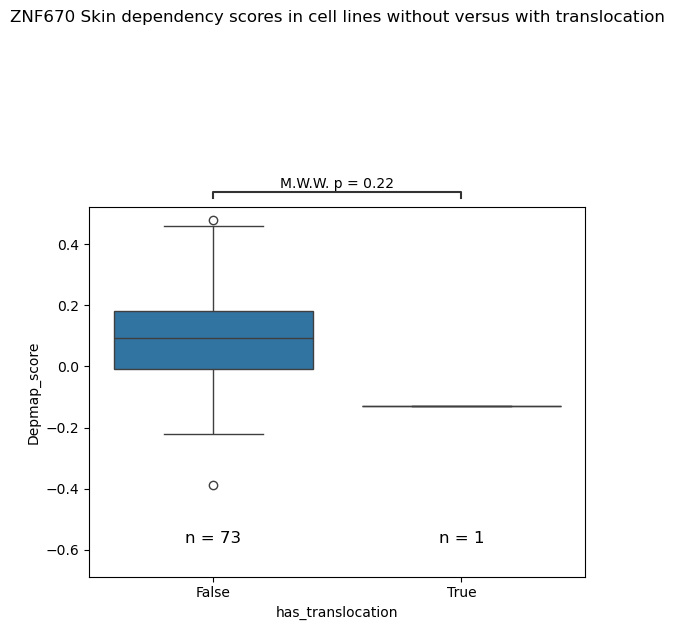

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=7.200e+01


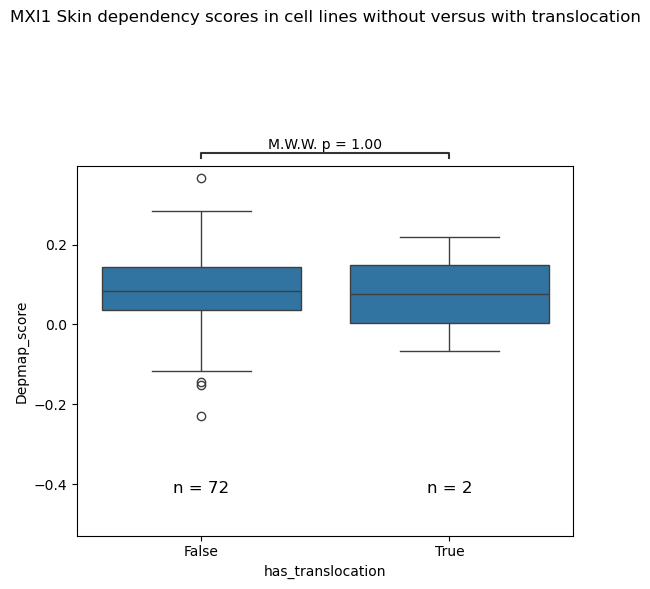

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:2.703e-02 U_stat=7.300e+01


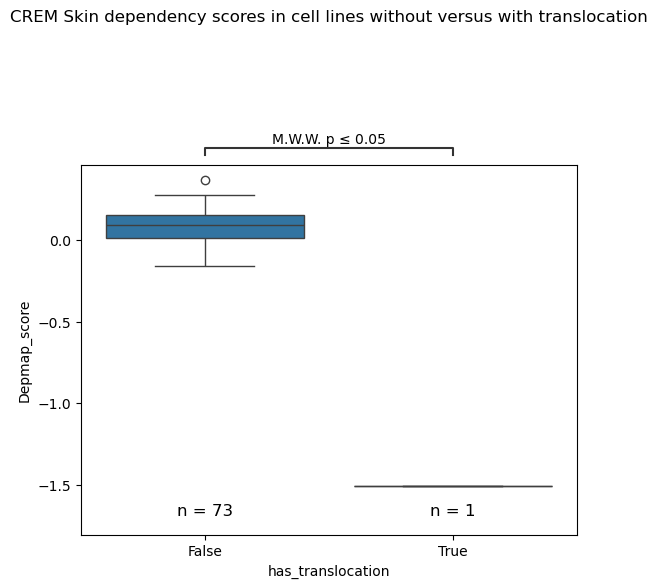

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:2.345e-01 U_stat=1.220e+02


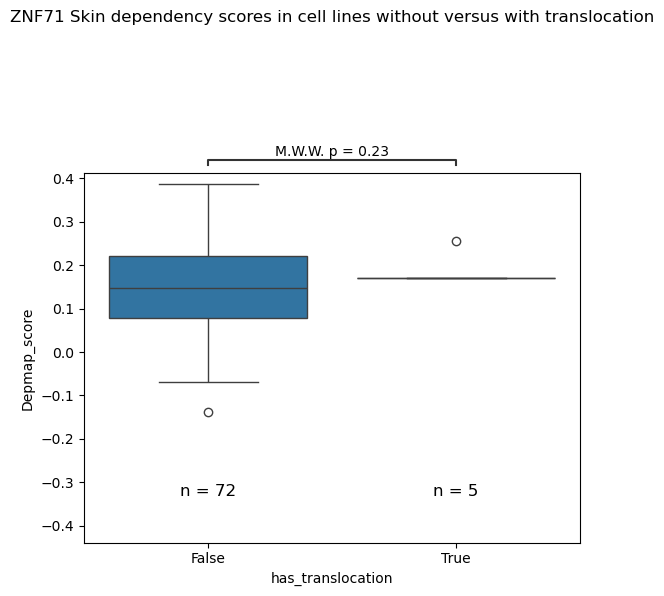

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:6.757e-01 U_stat=4.900e+01


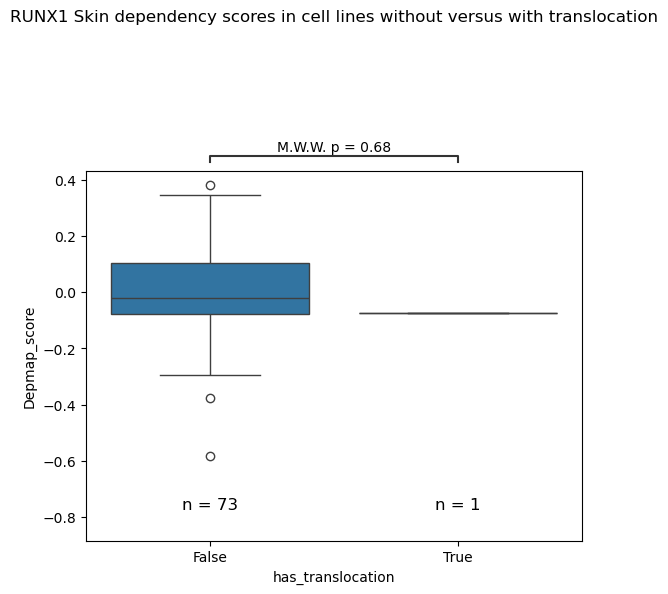

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:7.582e-01 U_stat=6.200e+01


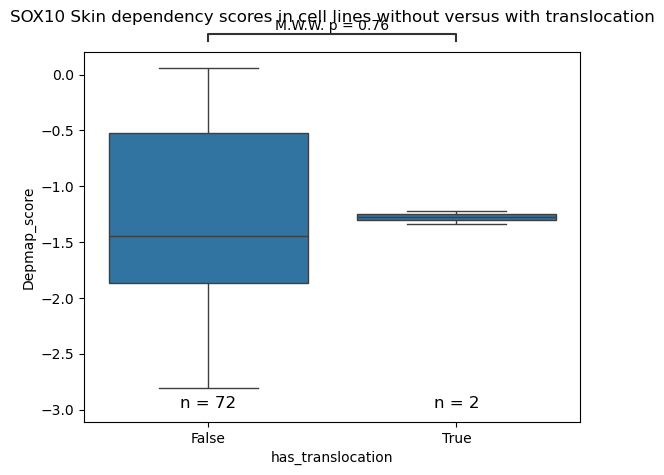

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.892e-01 U_stat=6.700e+01


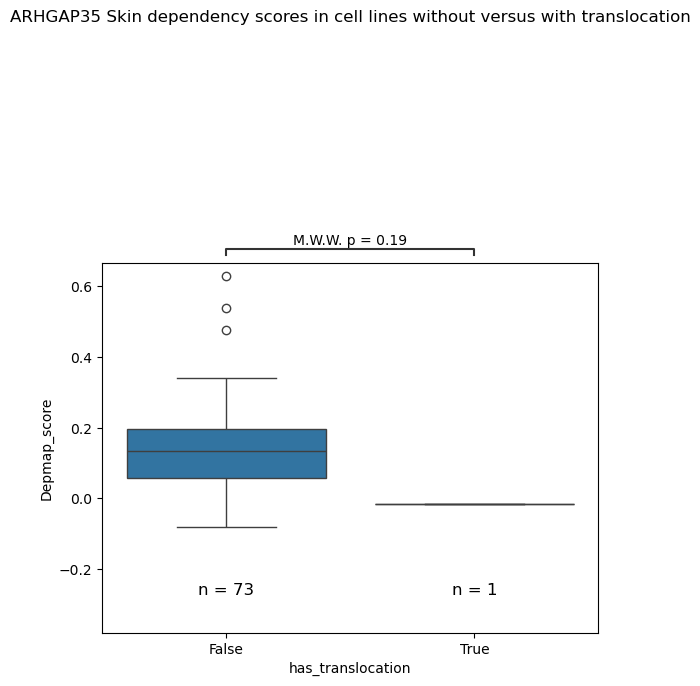

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.143e-01 U_stat=1.000e+00


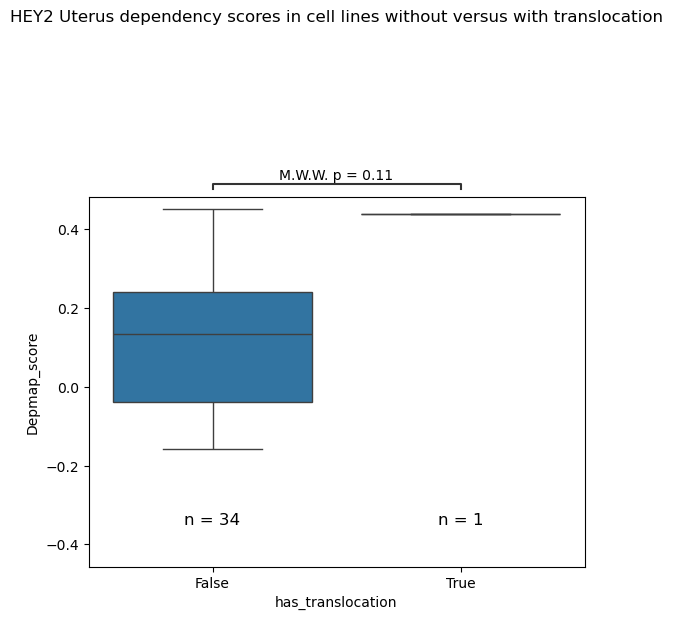

False vs. True: Mann-Whitney-Wilcoxon test two-sided, P_val:1.514e-01 U_stat=9.300e+01


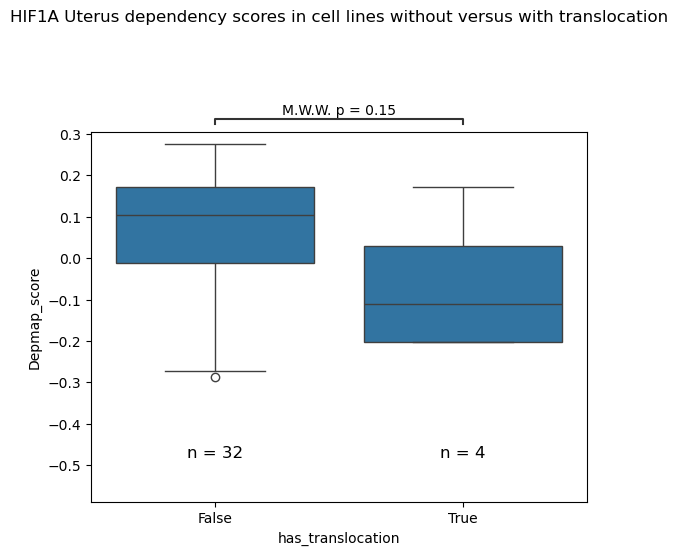

In [174]:
for lineage in ['Biliary Tract', 'Bone', 'Bowel', 'Breast', 'CNS/Brain',
       'Head and Neck', 'Lung', 'Lymphoid', 'Myeloid',
       'Ovary/Fallopian Tube', 'Pancreas', 'Pleura', 'Prostate', 'Skin',
       'Uterus']:
    for tf in unique_TFs:
        make_boxplot_specific_lineage(tf, lineage)